In [1]:
from matplotlib import pyplot as plt

import holidays
import datetime

import pandas as pd
import numpy as np



from prophet import Prophet
import pmdarima as pm

from scipy import stats, special
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Importing plotly failed. Interactive plots will not work.


In [2]:
def smape(actual, predicted) -> float:  
    temporary_smape_nominator = np.abs(np.array(actual) - np.array(predicted))
    temporary_smape_denominator = [np.max(elem) for elem in list(zip(predicted, actual))]

    return float(np.sum(temporary_smape_nominator) / np.sum(temporary_smape_denominator))

def regression_insights(actual, predicted) -> tuple: 
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    return mse, rmse, mae, r2

def bias(actual, predicted) -> float:
    return float(np.sum(np.abs(1 - np.array(predicted) / np.array(actual + 0.00000001))))

In [3]:
def week_year_to_date(week_year):
    # the '1' is for specifying the first day of the week
    return datetime.datetime.strptime(str(week_year) + '1', '%G%V%u')

In [4]:
weekly_data = pd.read_csv("../podaci/vremenske-serije/date_week_ds.csv")

In [5]:
weekly_data.tail(20)

,year_week,ds,demand_value
57,202103,2021-01-18,1.000000
58,202104,2021-01-25,1.132325
59,202105,2021-02-01,1.045369
60,202106,2021-02-08,0.909263
61,202107,2021-02-15,0.939509
62,202108,2021-02-22,1.122873
63,202109,2021-03-01,1.017013
64,202110,2021-03-08,1.018904
65,202111,2021-03-15,0.930057
66,202112,2021-03-22,1.015123


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


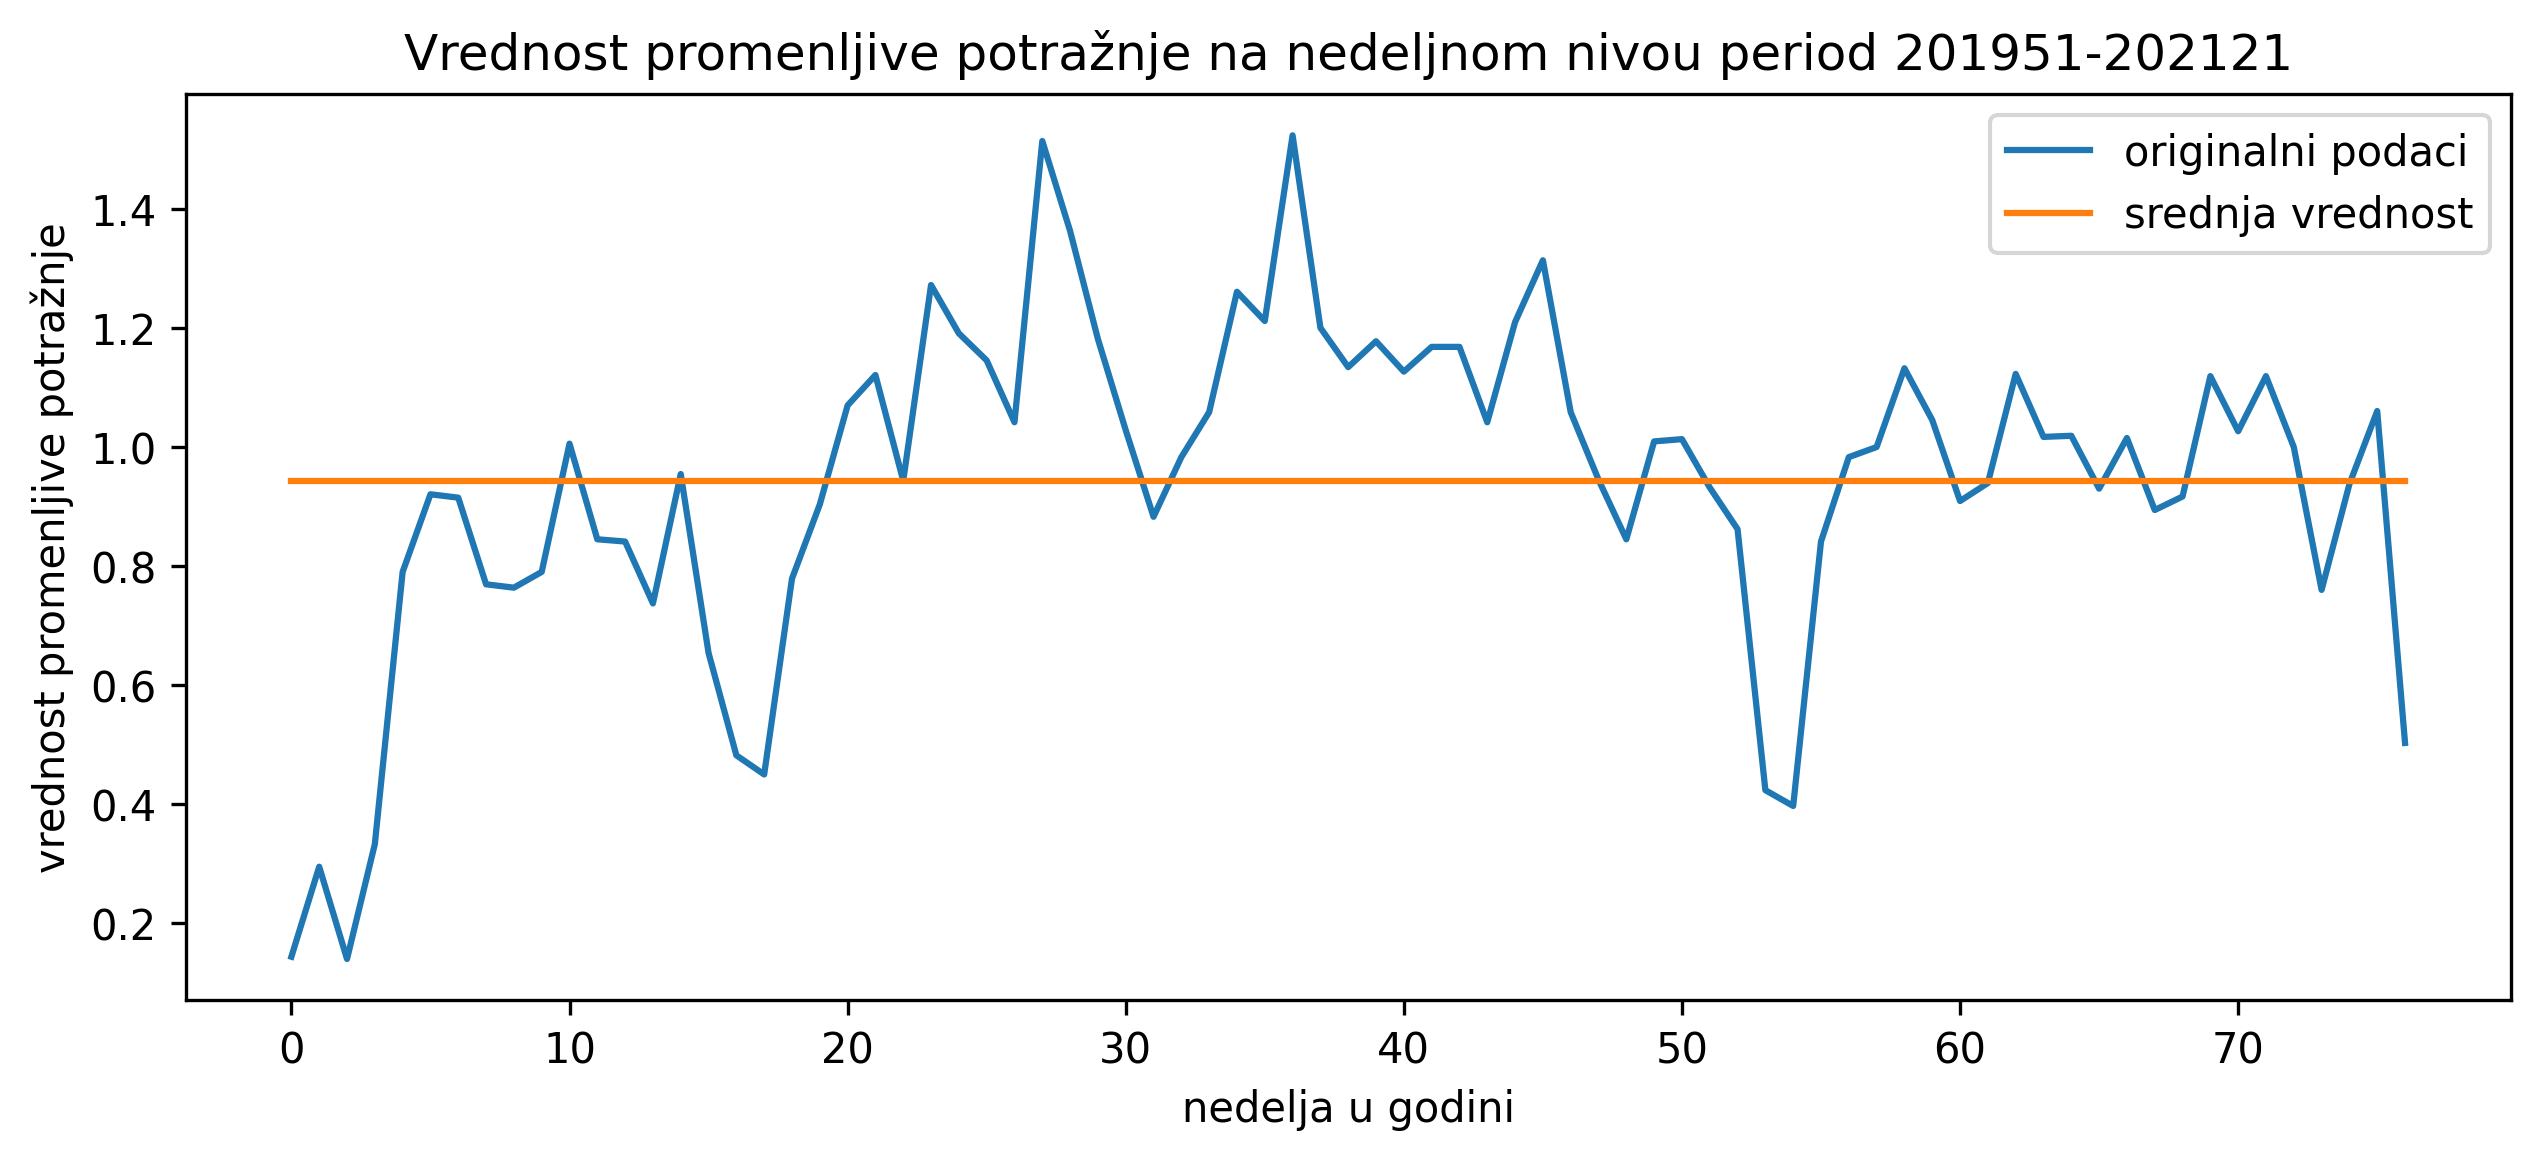

In [6]:
x_size = len(weekly_data["demand_value"])

plt.rcParams.update({'figure.figsize':(10, 4), 'figure.dpi':300})
plt.plot(weekly_data["demand_value"], label="originalni podaci")
plt.plot(np.arange(0, x_size, 1), 
         np.repeat(np.mean(weekly_data["demand_value"]), 
                   x_size), 
         label="srednja vrednost")

plt.title("Vrednost promenljive potražnje na nedeljnom nivou period 201951-202121")
plt.xlabel("nedelja u godini")
plt.ylabel("vrednost promenljive potražnje")
plt.legend()
plt.savefig("../../grafici/nedeljna_vremenska_serija.eps", dpi=300)

In [7]:
def plot_timeseries(data, column="demand_value", granularity="dani"):
    size_df = len(data[column])
    
    plt.rcParams.update({'figure.figsize':(11, 5), 'figure.dpi':300})
    plt.plot(data[column], 
             label="original")
    plt.plot(np.arange(0, size_df, 1), 
             np.repeat(np.mean(data[column]), size_df),
             label="srednja vrednost")
    
    plt.title("Vrednost promenljive potražnje tokom vremena")
    plt.xlabel(f"{granularity}")
    plt.ylabel("promenljiva potražnje")
    plt.legend()
#     plt.savefig("../../vremenska_serija_primer.eps", dpi=300)

def auto_diffs(df, target="demand_value", test="adf"):
    print(f'Originalni podaci diff d: {pm.arima.utils.ndiffs(df[target], test=test, max_d=3)}')
    print(f'Originalni podaci diff D: {pm.arima.utils.nsdiffs(df[target], m=6, max_D=10)}')


def probplot(df, target="demand_value"):
    plt.rcParams.update({'figure.figsize':(8, 7), 'figure.dpi':90})
    fig = plt.figure()

    ax1 = fig.add_subplot(411)
    prob = stats.probplot(df[target], dist='norm', plot=ax1)
    ax1.set_xlabel('')
    ax1.set_title('Probplot u odnosu na normalnu distribuciju')

    ax2 = fig.add_subplot(412)
    prob = stats.probplot(df[target].diff().dropna(), dist='norm', plot=ax2)
    ax2.set_xlabel('')
    ax2.set_title('Probplot za jednom diferencirane (y(t) - y(t-1)) originalne podatke')

    ax3 = fig.add_subplot(413)
    prob = stats.probplot(df[target].diff().diff().dropna(), dist='norm', plot=ax3)
    ax3.set_xlabel('')
    ax3.set_title('Probplot za 2 puta diferencirane originalne podatke')

    ax4 = fig.add_subplot(414)
    prob = stats.probplot(df[target].diff().diff().diff().dropna(), dist='norm', plot=ax4)
    ax4.set_title('Probplot za 3 puta diferencirane originalne podatke')

    plt.tight_layout()
    plt.show()

def plot_acf_pacf(df, diff_period=6, target="demand_value", lags_acf=40, lags_pacf=20):
    plt.rcParams.update({'figure.figsize':(12, 10), 'figure.dpi':300})

    fig, axs = plt.subplots(3, 2)

    plot_acf(df[target], ax=axs[0, 0], lags=lags_acf, alpha=0.05)
    axs[0, 0].set_title("Originalni podaci ACF")
    plot_acf(df[target].diff().dropna(), ax=axs[1, 0], lags=lags_acf, alpha=0.05)
    axs[1, 0].set_title("1 diff() originalni podaci ACF")
    plot_acf(df[target].diff().diff().dropna(), ax=axs[2, 0], lags=lags_acf, alpha=0.05)
    axs[2, 0].set_title("2 diff().diff() originalni podaci ACF")
#     plot_acf(df[target].diff(periods=diff_period).dropna(), ax=axs[2, 0], lags=lags_acf, alpha=0.05)
#     axs[2, 0].set_title(f"diff(periods={diff_period}) originalni podaci ACF")
#     plot_acf(df[target].diff(periods=diff_period).diff(periods=diff_period).dropna(), ax=axs[4, 0], lags=lags_acf, alpha=0.05)
#     axs[4, 0].set_title(f"diff(periods={diff_period}).diff(periods={diff_period}) originalni podaci ACF")

    plot_pacf(df[target], ax=axs[0, 1], lags=lags_pacf, alpha=0.05)
    axs[0, 1].set_title("Originalni podaci PACF")
    plot_pacf(df[target].diff().dropna(), ax=axs[1, 1], lags=lags_pacf, alpha=0.05)
    axs[1, 1].set_title("1 diff() originalni podaci PACF")
    plot_pacf(df[target].diff().diff().dropna(), ax=axs[2, 1], lags=lags_pacf, alpha=0.05)
    axs[2, 1].set_title("2 diff().diff() originalni podaci PACF")
#     plot_pacf(df[target].diff(periods=diff_period).dropna(), ax=axs[2, 1], lags=lags_pacf, alpha=0.05)
#     axs[2, 1].set_title(f"diff(periods={diff_period}) originalni podaci PACF")
#     plot_pacf(df[target].diff(periods=diff_period).diff(periods=diff_period).dropna(), ax=axs[4, 1], lags=lags_pacf, alpha=0.05)
#     axs[4, 1].set_title(f"diff(periods={diff_period}).diff(periods={diff_period}) originalni podaci PACF")

    plt.tight_layout()
    plt.savefig("../../grafici/acf_pacf_nedeljni.png", dpi=300)
    plt.show()

def test_stationarity(timeseries, rolling_param=14):
    rolmean = timeseries.rolling(rolling_param).mean()
    rolstd = timeseries.rolling(rolling_param).std()

    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Kotrljajuća srednja vrednost')
    plt.plot(rolstd, color='black', label = 'Kotrljajuća standardna devijacija')
    plt.legend(loc='best')
    plt.title('Kotrljajuća srednja vrednost i standardna devijacija')
    plt.show(block=False)

    print("Rezultati Dickey-Fuller Testa")
    adft = adfuller(timeseries, autolag='AIC')
    output = pd.Series(adft[0:4],
                       index=['Test Statistics',
                              'p-value',
                              'No. of lags used',
                              'Number of observations used'])
    
    for key, values in adft[4].items():
        output['critical value (%s)' % key] =  values
    print(output)

def auto_arima(df, target="demand_value", m=30.5):
    auto_model = pm.auto_arima(df[target], 
                               start_p=0,
                               start_q=0, 
                               max_p=6,
                               max_q=6, 
                               d=0, 
                               D=0, 
                               start_P=0,
                               start_Q=0, 
                               max_P=6, 
                               max_Q=6, 
                               m=m,
                               stepwise=True, 
                               approximation=False,
                               seasonal=True)
#     auto_model.summary() 
  
    return auto_model

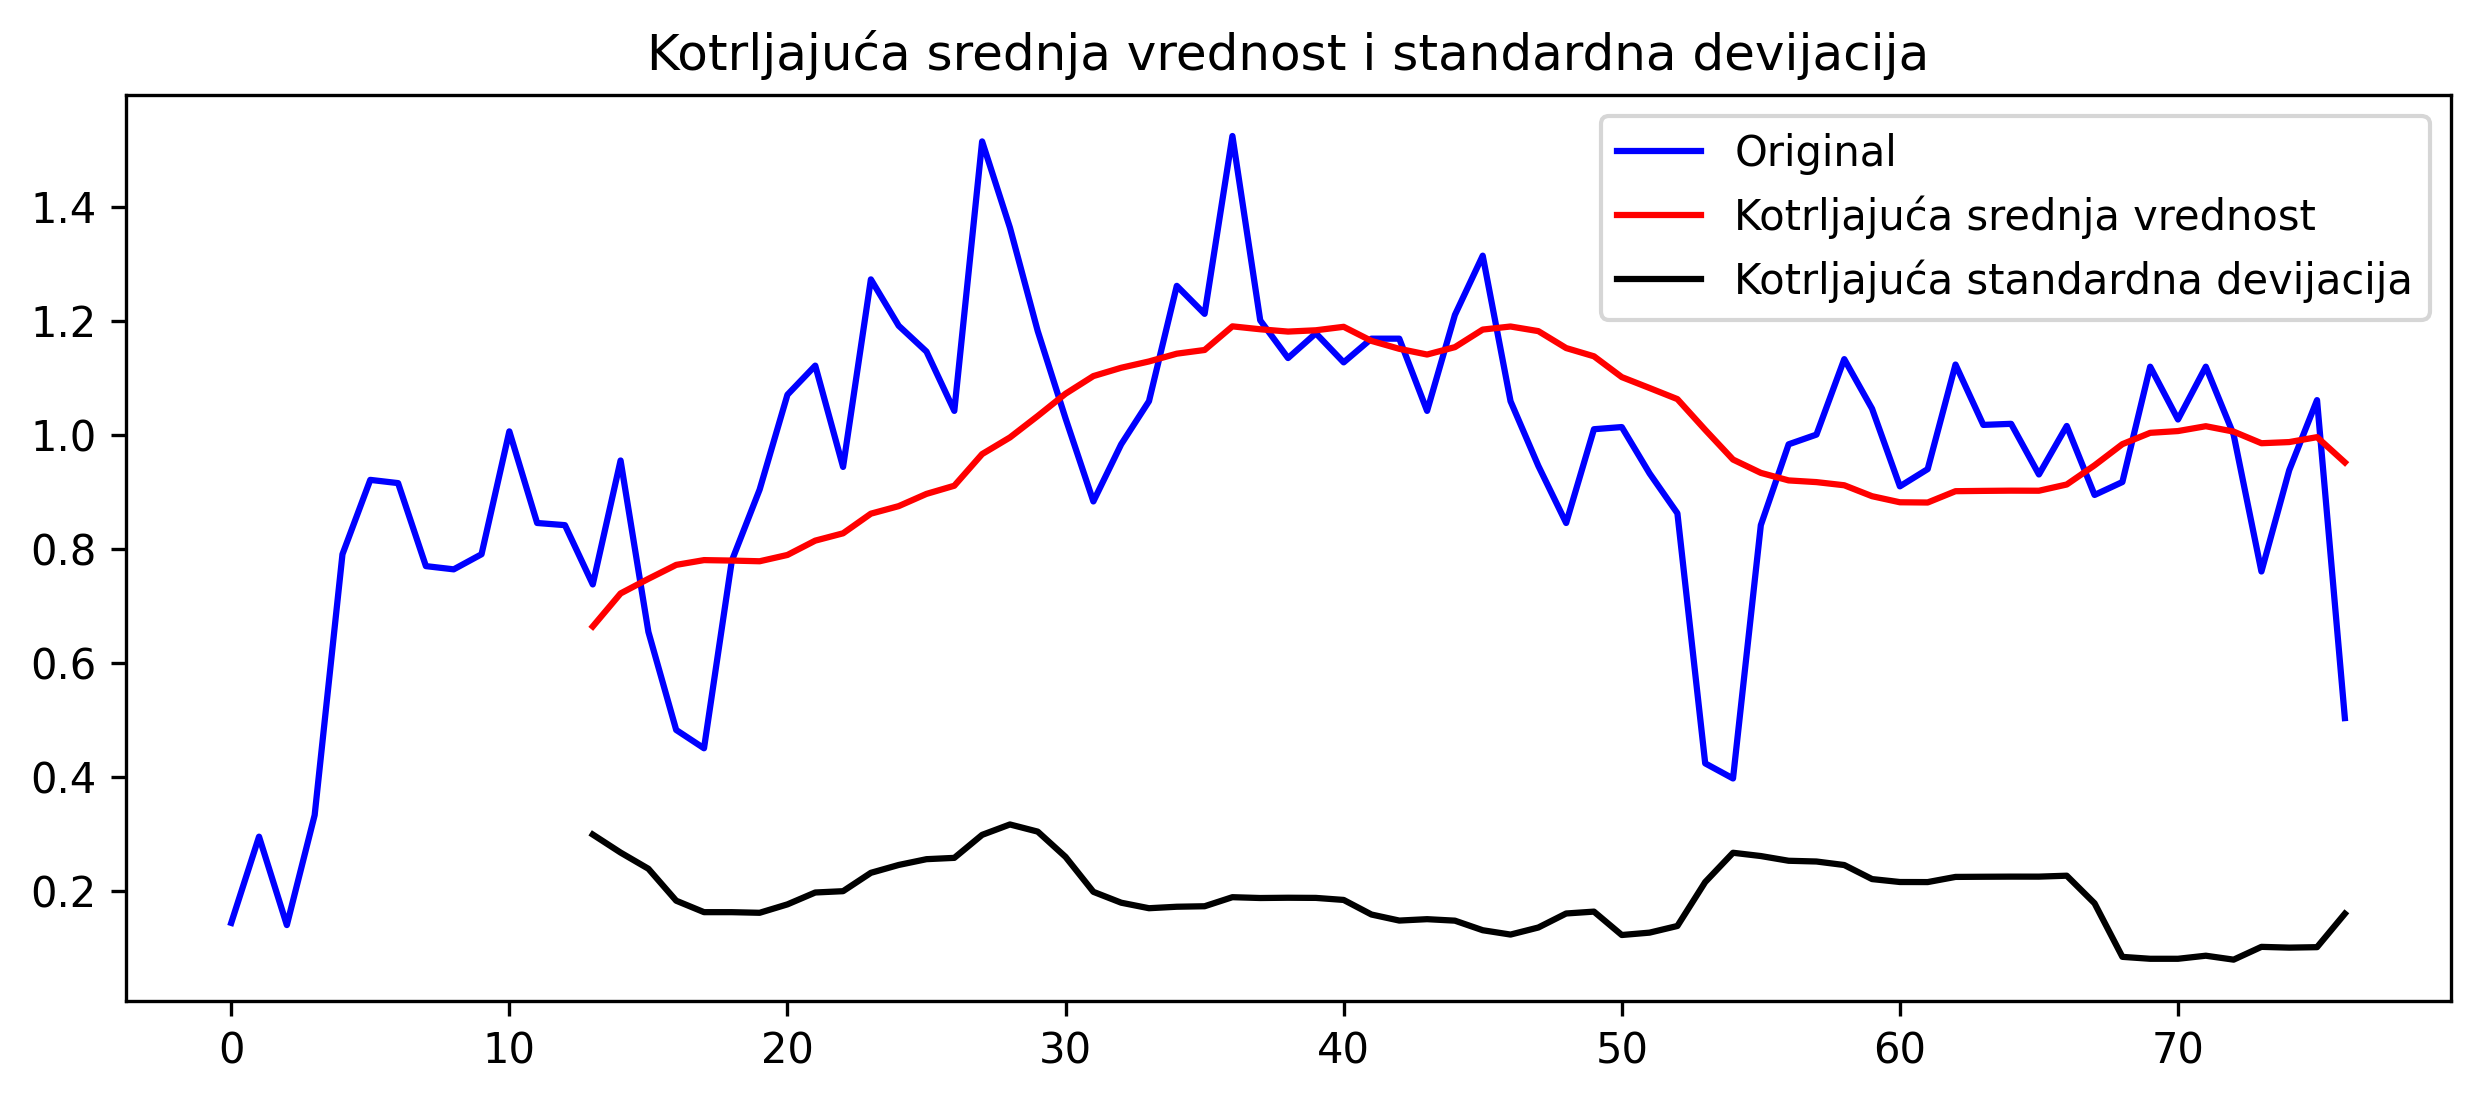

Rezultati Dickey-Fuller Testa
Test Statistics                -3.833352
p-value                         0.002584
No. of lags used                0.000000
Number of observations used    76.000000
critical value (1%)            -3.519481
critical value (5%)            -2.900395
critical value (10%)           -2.587498
dtype: float64


In [8]:
# If the p-value is less than 0.05, we reject the null hypothesis
test_stationarity(weekly_data['demand_value'])

In [9]:
X = weekly_data['demand_value']
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print(f'srednja_vrednost_1 = {np.round(mean1, 3)}, srednja_vrednost_2 = {np.round(mean2, 3)}')
print(f'varijansa_1 = {np.round(var1, 3)}, varijansa_2 = {np.round(var2, 3)}')

srednja_vrednost_1 = 0.908, srednja_vrednost_2 = 0.977
varijansa_1 = 0.114, varijansa_2 = 0.038


In [10]:
# AR -> PACF, imamo 1 dok sledeći ne uleti u plavi deo
# MA -> ACF, imamo 2 stubića iznad ili ispod plavog dela, dok sledeći ne uleti u plavi deo
# (1, 0, 2) model?

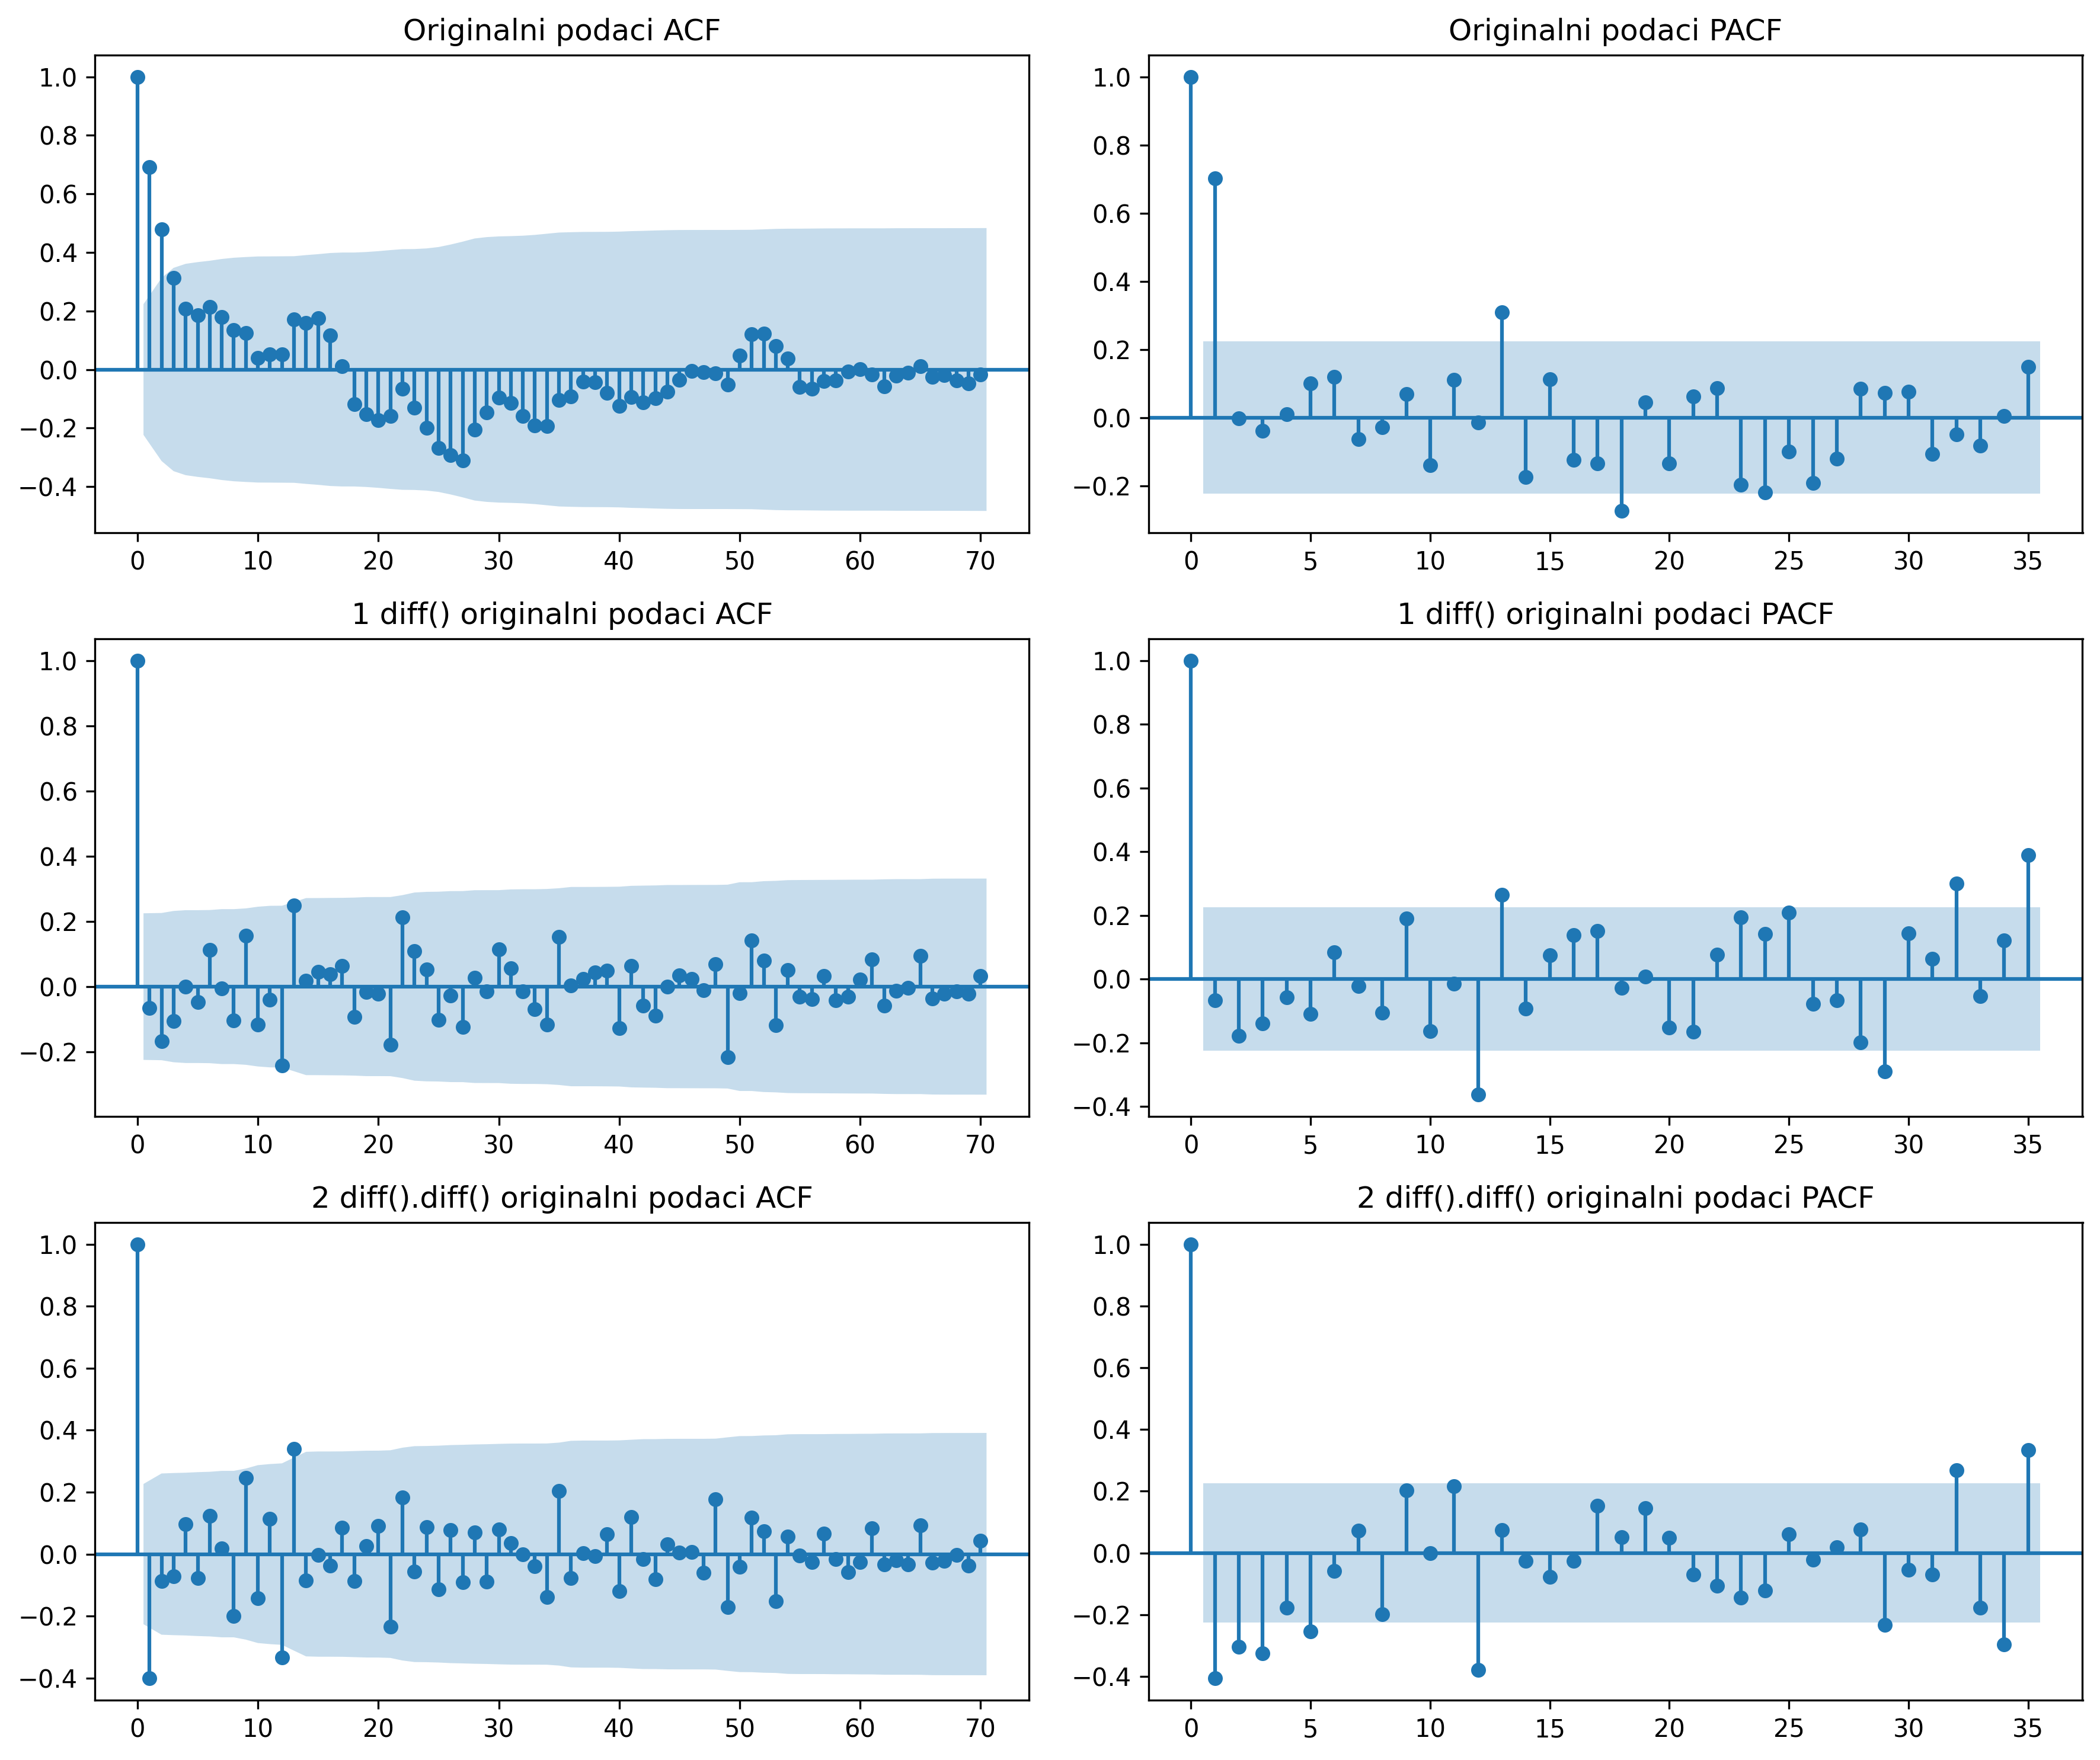

In [11]:
plot_acf_pacf(weekly_data, 
              diff_period=0, 
              lags_acf=70, 
              lags_pacf=35
             )

In [12]:
auto_model = auto_arima(weekly_data, m=30.5)
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   77
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  22.122
Date:                Wed, 21 Jul 2021   AIC                            -38.245
Time:                        01:07:11   BIC                            -31.213
Sample:                             0   HQIC                           -35.432
                                 - 77                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1788      0.052      3.409      0.001       0.076       0.282
ar.L1          0.7980      0.064     12.416      0.000       0.672       0.924
sigma2         0.0325      0.004      7.329      0.000       0.024       0.041
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 3.79
Prob(Q):                              0.77   Prob(JB):                         0.15
Heteroskedasticity (H):               0.97   Skew:                            -0.22
Prob(H) (two-sided):                  0.93   Kurtosis:                         4.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.41190D-01    |proj g|=  1.23827D-01

At iterate    5    f= -2.42214D-01    |proj g|=  1.08538D-01

At iterate   10    f= -2.42342D-01    |proj g|=  3.64036D-03

At iterate   15    f= -2.42481D-01    |proj g|=  6.29851D-02

At iterate   20    f= -2.43619D-01    |proj g|=  3.66323D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     27      1     0     0   1.547D-07  -2.436D-01
  F = -0.24363249924951808     

CONVERG

 This problem is unconstrained.
/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


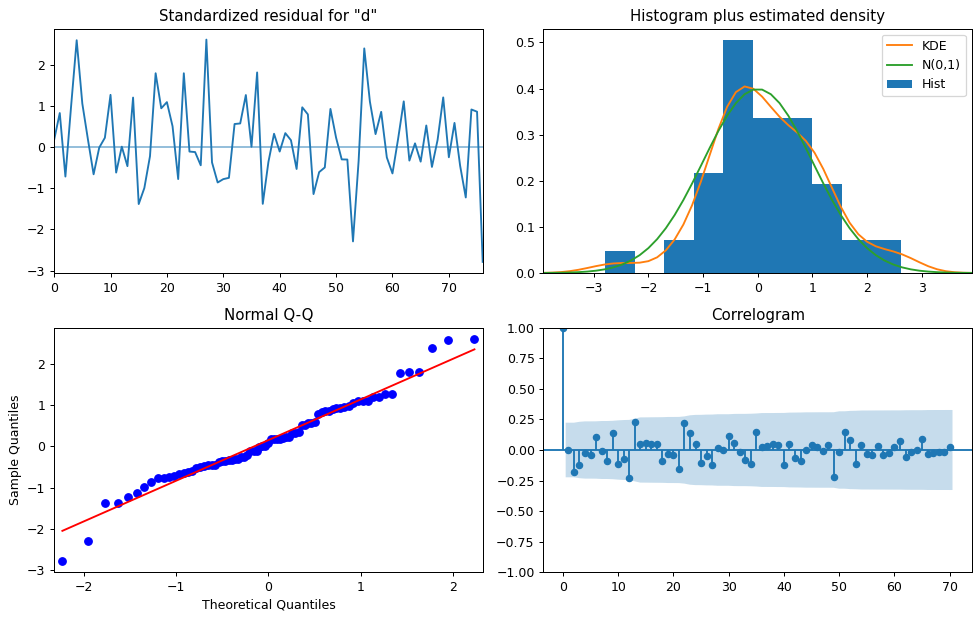

In [13]:
best_model = SARIMAX(weekly_data["demand_value"], 
                     order=(1, 0, 1),
                     seasonal_order=(0, 0, 0, 0)
                    ).fit()

print(best_model.summary())
plt.rcParams.update({'figure.figsize':(11, 7), 'figure.dpi':90})

# Standardized residuals over time
# Histogram plus estimated density of standardized residuals, along with a N(0,1) density plotted for reference
# Normal Q-Q plot, with Normal reference line.
# Correlogram
best_model.plot_diagnostics(lags=70)
plt.tight_layout()

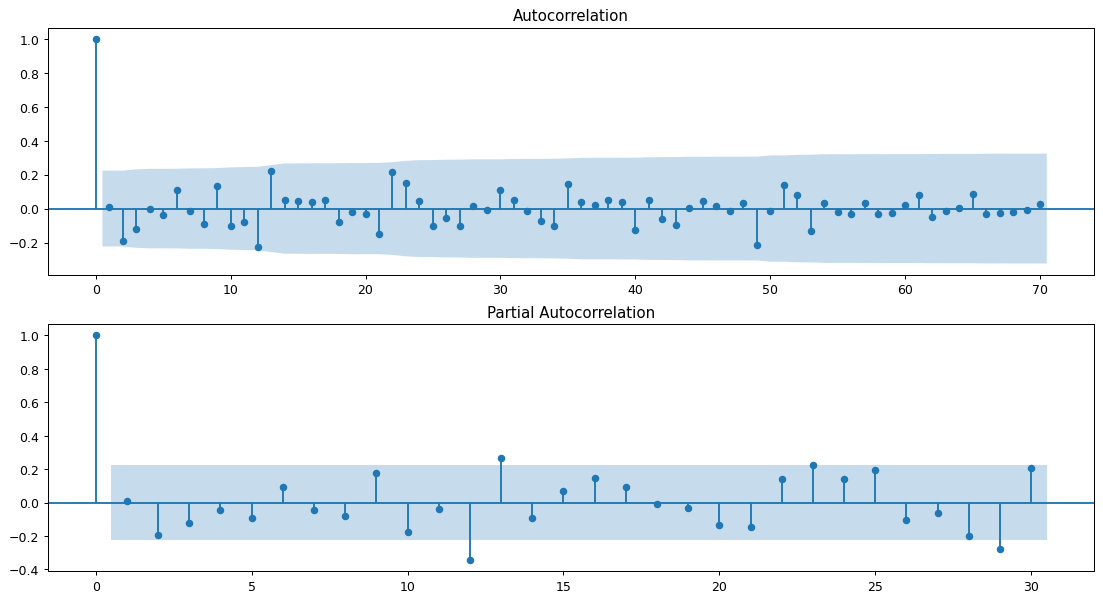

In [14]:
residuals = best_model.resid
fig, ax = plt.subplots(2, 1, figsize=(15,8))
fig = plot_acf(residuals, lags=70, ax=ax[0])
fig = plot_pacf(residuals, lags=30, ax=ax[1])
plt.show()

In [15]:
pm.auto_arima(weekly_data["demand_value"], 
                           start_p=0,
                           start_q=0, 
                           max_p=5,
                           max_q=5, 
                           d=0,
                           max_d=3,
                           stepwise=True, 
                           approximation=False,
                           trace=True,
                           suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=22.483, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-38.245, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-15.553, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=217.689, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-36.368, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-36.397, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-34.469, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-33.110, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.442 seconds


ARIMA(order=(1, 0, 0), scoring_args={}, suppress_warnings=True)

In [16]:
# year_week: 202109 -> date: 2021-03-01

def run_prophet(prophet_train_pd, 
                prophet_test_pd, 
                model_info, 
                look_ahead=4):
    history = prophet_train_pd.copy()

    predictions = []
  
    # if needed at some point to see coeffs
    forecasts_df = []

    for instance in range(len(prophet_test_pd)):
        model = eval(model_info)
        model.fit(history)

        # freq="W-MON" is to put Monday as an ancor, instead of Sunday
        # alternative: `+= np.timedelta64(1, 'D')`
        future_to_predict = model.make_future_dataframe(periods=look_ahead, freq="W-MON", include_history=False)
        forecast = model.predict(future_to_predict)
        forecasts_df.append(forecast)

        ys_predicted = forecast['yhat'].values

        dates = [pd.to_datetime(x).date() for x in future_to_predict['ds'].values]
        date_prediction = list(zip(dates, ys_predicted))
        predictions.append(date_prediction)

        test_instance = prophet_test_pd.iloc[instance]
        history = history.append(test_instance)

#   create_prediction_plot(prophet_train_pd, prophet_test_pd, predictions, look_ahead, "202108", (1,1,1), "prophet")
    return predictions, forecasts_df, prophet_train_pd, prophet_test_pd, model


def run_arima(arima_train_pd, 
              arima_test_pd, 
              model_info, 
              look_ahead=1):
    
    arima_train = arima_train_pd['y'].values
    arima_test = arima_test_pd['y'].values
  
    history = arima_train.copy()
    predictions = []

    for instance in range(len(arima_test_pd)):
        model = eval(model_info)
        model_fit = model.fit()

        start_date = arima_test_pd.iloc[instance]['ds']
        future_to_predict = [start_date + datetime.timedelta(days=t*7) for t in range(look_ahead)]
        output = model_fit.forecast(look_ahead)

        # forecast [0]
        # stderr   [1]
        # conf_int [2]
        if 'SARIMAX' in model_info:
            yhat = output
        else:
            yhat = output[0]
            
        date_prediction = list(zip(future_to_predict, yhat))
        predictions.append(date_prediction)
        history = np.append(history, arima_test_pd.iloc[instance]['y'])

    return predictions, arima_train_pd, arima_test_pd, model_fit


def run_model(model_info, data_sorted_by_date, year_week_col="year_week", week_to_start="202109", look_ahead=1):
    train_pd = data_sorted_by_date[data_sorted_by_date[year_week_col] < week_to_start]
    test_pd =  data_sorted_by_date[data_sorted_by_date[year_week_col] >= week_to_start]
        
    if ('ARIMA' in model_info) or ("SARIMAX" in model_info):
        print("Arima/Sarima")
        arima_predictions, arima_train_pd, arima_test_pd, arima_model = run_arima(train_pd, test_pd, model_info, look_ahead)
        return arima_predictions, arima_model
  
    elif 'Prophet' in model_info:
        print("Prophet")
        prophet_predictions, prophet_forecasts_df, prophet_train_pd, prophet_test_pd, prophet_model = run_prophet(train_pd, test_pd, model_info, look_ahead)
        return prophet_predictions, prophet_model
  
    else:
        print(f"That model ({model_info}) is not supported.")

In [17]:
weekly_data = weekly_data.astype({"year_week": 'str', "ds": 'datetime64[ns]'})
weekly_data = weekly_data.rename(columns={"demand_value": "y"})
weekly_data.dtypes
# data_sorted_by_date[data_sorted_by_date[year_week_col] >= week_to_start]

year_week            object
ds           datetime64[ns]
y                   float64
dtype: object

In [18]:
models = {
  "prophet_weekly_and_monthly_and_holidays": "Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False).add_seasonality(name='monthly', period=30.5, fourier_order=5).add_country_holidays(country_name='SWE')",
  "prophet_weekly_and_monthly_and_holidays_more_flexible_trend": "Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False, changepoint_prior_scale=0.09).add_seasonality(name='monthly', period=30.5, fourier_order=5).add_country_holidays(country_name='SWE')",
  "arima_1_0_0": "ARIMA(history, order=(1, 0, 0))",
  "arima_1_1_1": "ARIMA(history, order=(1, 1, 1))",
  "arima_1_0_2": "ARIMA(history, order=(1, 0, 2))",
  "arima_12_1_0": "ARIMA(history, order=(12, 1, 0))",
  "arima_13_0_2": "ARIMA(history, order=(13, 0, 2))",
}

results = {}
WEEK_TO_START = "202109"
WEEKS_TO_LOOK_AHEAD = 4

for model_name, model_info in models.items():
    print(model_info)  
    run_returned = run_model(model_info=model_info, 
                           data_sorted_by_date=weekly_data, 
                           year_week_col="year_week",
                           week_to_start=WEEK_TO_START, 
                           look_ahead=WEEKS_TO_LOOK_AHEAD)
    
    results[model_name] = run_returned
    print()

Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False).add_seasonality(name='monthly', period=30.5, fourier_order=5).add_country_holidays(country_name='SWE')
Prophet

Initial log joint probability = -116.609
Iteration  1. Log joint probability =    36.2361. Improved by 152.845.
Iteration  2. Log joint probability =     68.468. Improved by 32.2319.
Iteration  3. Log joint probability =    83.0687. Improved by 14.6007.
Iteration  4. Log joint probability =    83.2525. Improved by 0.183736.
Iteration  5. Log joint probability =    83.2552. Improved by 0.00272075.
Iteration  6. Log joint probability =    83.2953. Improved by 0.0401541.
Iteration  7. Log joint probability =    83.4423. Improved by 0.146949.
Iteration  8. Log joint probability =    83.6094. Improved by 0.167076.
Iteration  9. Log joint probability =    83.6583. Improved by 0.0489035.
Iteration 10. Log joint probability =    83.7019. Improved by 0.0435846.
Iteration 11. Log joint probability =    


Initial log joint probability = -118.892
Iteration  1. Log joint probability =    35.2981. Improved by 154.19.
Iteration  2. Log joint probability =    70.4575. Improved by 35.1594.
Iteration  3. Log joint probability =    85.4161. Improved by 14.9586.
Iteration  4. Log joint probability =    86.5756. Improved by 1.15951.
Iteration  5. Log joint probability =    86.5784. Improved by 0.00277301.
Iteration  6. Log joint probability =    86.5862. Improved by 0.00785785.
Iteration  7. Log joint probability =    86.6361. Improved by 0.0499049.
Iteration  8. Log joint probability =    86.8416. Improved by 0.205435.
Iteration  9. Log joint probability =     86.889. Improved by 0.0474668.
Iteration 10. Log joint probability =    86.8962. Improved by 0.00721629.
Iteration 11. Log joint probability =    86.9346. Improved by 0.0383995.
Iteration 12. Log joint probability =    86.9737. Improved by 0.0390283.
Iteration 13. Log joint probability =    86.9979. Improved by 0.0242342.
Iteration 14. Lo


Initial log joint probability = -120.853
Iteration  1. Log joint probability =    41.9805. Improved by 162.833.
Iteration  2. Log joint probability =    69.7064. Improved by 27.726.
Iteration  3. Log joint probability =     85.655. Improved by 15.9486.
Iteration  4. Log joint probability =    89.9976. Improved by 4.34257.
Iteration  5. Log joint probability =    90.0626. Improved by 0.0650323.
Iteration  6. Log joint probability =    90.1156. Improved by 0.0529722.
Iteration  7. Log joint probability =    90.1483. Improved by 0.032685.
Iteration  8. Log joint probability =    90.1525. Improved by 0.00426174.
Iteration  9. Log joint probability =    90.2656. Improved by 0.113066.
Iteration 10. Log joint probability =    90.4015. Improved by 0.135898.
Iteration 11. Log joint probability =    90.4465. Improved by 0.0449684.
Iteration 12. Log joint probability =    90.4783. Improved by 0.0318401.
Iteration 13. Log joint probability =    90.4798. Improved by 0.00146726.
Iteration 14. Log j


Initial log joint probability = -123.245
Iteration  1. Log joint probability =    33.3881. Improved by 156.633.
Iteration  2. Log joint probability =    64.1789. Improved by 30.7909.
Iteration  3. Log joint probability =    88.0608. Improved by 23.8819.
Iteration  4. Log joint probability =    92.4106. Improved by 4.34978.
Iteration  5. Log joint probability =    92.5114. Improved by 0.100837.
Iteration  6. Log joint probability =    92.5818. Improved by 0.0703544.
Iteration  7. Log joint probability =    92.6264. Improved by 0.0446625.
Iteration  8. Log joint probability =    92.6494. Improved by 0.0229177.
Iteration  9. Log joint probability =    92.8136. Improved by 0.164269.
Iteration 10. Log joint probability =    92.8445. Improved by 0.0308293.
Iteration 11. Log joint probability =    92.8789. Improved by 0.0344053.
Iteration 12. Log joint probability =    93.4575. Improved by 0.578617.
Iteration 13. Log joint probability =    93.4877. Improved by 0.0302061.
Iteration 14. Log jo


Initial log joint probability = -124.699
Iteration  1. Log joint probability =    15.3588. Improved by 140.057.
Iteration  2. Log joint probability =    69.2972. Improved by 53.9384.
Iteration  3. Log joint probability =    90.9499. Improved by 21.6526.
Iteration  4. Log joint probability =    90.9885. Improved by 0.0386475.
Iteration  5. Log joint probability =    90.9923. Improved by 0.0037918.
Iteration  6. Log joint probability =    91.1288. Improved by 0.136551.
Iteration  7. Log joint probability =    91.1592. Improved by 0.0303498.
Iteration  8. Log joint probability =     91.248. Improved by 0.0887908.
Iteration  9. Log joint probability =    91.2644. Improved by 0.0164485.
Iteration 10. Log joint probability =    91.2718. Improved by 0.00740895.
Iteration 11. Log joint probability =    91.4663. Improved by 0.194494.
Iteration 12. Log joint probability =    91.4679. Improved by 0.0015993.
Iteration 13. Log joint probability =    92.1172. Improved by 0.64924.
Iteration 14. Log 


Initial log joint probability = -126.759
Iteration  1. Log joint probability =     47.127. Improved by 173.886.
Iteration  2. Log joint probability =    86.3804. Improved by 39.2534.
Iteration  3. Log joint probability =    100.237. Improved by 13.8567.
Iteration  4. Log joint probability =    100.856. Improved by 0.618893.
Iteration  5. Log joint probability =    100.899. Improved by 0.0430994.
Iteration  6. Log joint probability =     100.91. Improved by 0.01101.
Iteration  7. Log joint probability =    100.944. Improved by 0.0336923.
Iteration  8. Log joint probability =    100.954. Improved by 0.0102304.
Iteration  9. Log joint probability =    100.962. Improved by 0.00821493.
Iteration 10. Log joint probability =    100.976. Improved by 0.0135295.
Iteration 11. Log joint probability =    100.982. Improved by 0.00604762.
Iteration 12. Log joint probability =    100.989. Improved by 0.00735094.
Iteration 13. Log joint probability =     100.99. Improved by 0.00115224.
Iteration 14. 


Initial log joint probability = -129.021
Iteration  1. Log joint probability =    23.1896. Improved by 152.21.
Iteration  2. Log joint probability =    85.1515. Improved by 61.9619.
Iteration  3. Log joint probability =    101.946. Improved by 16.7946.
Iteration  4. Log joint probability =    102.798. Improved by 0.851867.
Iteration  5. Log joint probability =    102.814. Improved by 0.0157385.
Iteration  6. Log joint probability =    102.885. Improved by 0.071525.
Iteration  7. Log joint probability =    103.168. Improved by 0.283254.
Iteration  8. Log joint probability =    103.348. Improved by 0.179044.
Iteration  9. Log joint probability =    103.365. Improved by 0.0179085.
Iteration 10. Log joint probability =    103.409. Improved by 0.0432218.
Iteration 11. Log joint probability =    103.482. Improved by 0.0733237.
Iteration 12. Log joint probability =    103.538. Improved by 0.0559204.
Iteration 13. Log joint probability =    103.565. Improved by 0.0269848.
Iteration 14. Log jo


Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False, changepoint_prior_scale=0.09).add_seasonality(name='monthly', period=30.5, fourier_order=5).add_country_holidays(country_name='SWE')
Prophet

Initial log joint probability = -131.304
Iteration  1. Log joint probability =    36.2277. Improved by 167.532.
Iteration  2. Log joint probability =    68.5628. Improved by 32.335.
Iteration  3. Log joint probability =    82.1148. Improved by 13.552.
Iteration  4. Log joint probability =    82.1676. Improved by 0.0527916.
Iteration  5. Log joint probability =    82.3444. Improved by 0.176781.
Iteration  6. Log joint probability =    82.3543. Improved by 0.0099608.
Iteration  7. Log joint probability =    82.4805. Improved by 0.126141.
Iteration  8. Log joint probability =    82.7808. Improved by 0.300324.
Iteration  9. Log joint probability =    82.9269. Improved by 0.146097.
Iteration 10. Log joint probability =    82.9424. Improved by 0.0154846.
Iteration 11. 


Initial log joint probability = -133.587
Iteration  1. Log joint probability =    35.2796. Improved by 168.867.
Iteration  2. Log joint probability =    70.5321. Improved by 35.2525.
Iteration  3. Log joint probability =    85.1469. Improved by 14.6148.
Iteration  4. Log joint probability =    85.2093. Improved by 0.0623447.
Iteration  5. Log joint probability =    85.2758. Improved by 0.0665677.
Iteration  6. Log joint probability =    85.3656. Improved by 0.0897177.
Iteration  7. Log joint probability =    85.3897. Improved by 0.0241511.
Iteration  8. Log joint probability =    87.1255. Improved by 1.7358.
Iteration  9. Log joint probability =    87.1857. Improved by 0.0601898.
Iteration 10. Log joint probability =    87.2007. Improved by 0.0150517.
Iteration 11. Log joint probability =    87.3836. Improved by 0.182827.
Iteration 12. Log joint probability =    87.3879. Improved by 0.00436467.
Iteration 13. Log joint probability =     87.419. Improved by 0.0310507.
Iteration 14. Log 


Initial log joint probability = -135.547
Iteration  1. Log joint probability =    41.9881. Improved by 177.535.
Iteration  2. Log joint probability =    69.4129. Improved by 27.4247.
Iteration  3. Log joint probability =    85.8539. Improved by 16.4411.
Iteration  4. Log joint probability =    89.8095. Improved by 3.95559.
Iteration  5. Log joint probability =    89.8265. Improved by 0.0169539.
Iteration  6. Log joint probability =    89.8857. Improved by 0.0592071.
Iteration  7. Log joint probability =    89.8962. Improved by 0.0105395.
Iteration  8. Log joint probability =    89.9399. Improved by 0.0436766.
Iteration  9. Log joint probability =    89.9793. Improved by 0.0393635.
Iteration 10. Log joint probability =    90.0041. Improved by 0.0247767.
Iteration 11. Log joint probability =    90.0094. Improved by 0.00533892.
Iteration 12. Log joint probability =    90.0941. Improved by 0.0847289.
Iteration 13. Log joint probability =    90.1233. Improved by 0.0292063.
Iteration 14. Lo


Initial log joint probability = -137.94
Iteration  1. Log joint probability =    33.4589. Improved by 171.399.
Iteration  2. Log joint probability =    64.1625. Improved by 30.7036.
Iteration  3. Log joint probability =    87.5766. Improved by 23.4141.
Iteration  4. Log joint probability =    87.6841. Improved by 0.107542.
Iteration  5. Log joint probability =     87.705. Improved by 0.0208827.
Iteration  6. Log joint probability =    87.7523. Improved by 0.047345.
Iteration  7. Log joint probability =    87.7619. Improved by 0.00959269.
Iteration  8. Log joint probability =    87.7864. Improved by 0.0244863.
Iteration  9. Log joint probability =    87.8183. Improved by 0.0318483.
Iteration 10. Log joint probability =    87.8342. Improved by 0.0159025.
Iteration 11. Log joint probability =    87.9801. Improved by 0.145983.
Iteration 12. Log joint probability =    89.7514. Improved by 1.77126.
Iteration 13. Log joint probability =    89.8906. Improved by 0.139185.
Iteration 14. Log joi


Initial log joint probability = -139.393
Iteration  1. Log joint probability =    15.2546. Improved by 154.648.
Iteration  2. Log joint probability =    69.6947. Improved by 54.4401.
Iteration  3. Log joint probability =    69.7145. Improved by 0.0198169.
Iteration  4. Log joint probability =    69.7357. Improved by 0.0211814.
Iteration  5. Log joint probability =    69.7836. Improved by 0.0479255.
Iteration  6. Log joint probability =    69.8331. Improved by 0.0495352.
Iteration  7. Log joint probability =    69.8455. Improved by 0.0123493.
Iteration  8. Log joint probability =    69.9545. Improved by 0.108993.
Iteration  9. Log joint probability =    90.0572. Improved by 20.1028.
Iteration 10. Log joint probability =    90.1762. Improved by 0.118968.
Iteration 11. Log joint probability =    90.2108. Improved by 0.0346382.
Iteration 12. Log joint probability =    90.4766. Improved by 0.265785.
Iteration 13. Log joint probability =    90.4915. Improved by 0.014897.
Iteration 14. Log j


Initial log joint probability = -140.022
Iteration  1. Log joint probability =    43.7483. Improved by 183.77.
Iteration  2. Log joint probability =    81.2222. Improved by 37.4739.
Iteration  3. Log joint probability =    95.9448. Improved by 14.7227.
Iteration  4. Log joint probability =    96.0399. Improved by 0.0950219.
Iteration  5. Log joint probability =    96.2052. Improved by 0.165284.
Iteration  6. Log joint probability =    96.2906. Improved by 0.0854416.
Iteration  7. Log joint probability =     96.378. Improved by 0.0873728.
Iteration  8. Log joint probability =    96.3828. Improved by 0.00481357.
Iteration  9. Log joint probability =    96.4207. Improved by 0.0378983.
Iteration 10. Log joint probability =    96.4771. Improved by 0.0563712.
Iteration 11. Log joint probability =    96.4911. Improved by 0.0140505.
Iteration 12. Log joint probability =    96.6205. Improved by 0.129428.
Iteration 13. Log joint probability =    96.7975. Improved by 0.176939.
Iteration 14. Log 


Initial log joint probability = -141.454
Iteration  1. Log joint probability =    47.1771. Improved by 188.631.
Iteration  2. Log joint probability =    85.2184. Improved by 38.0413.
Iteration  3. Log joint probability =    100.485. Improved by 15.2664.
Iteration  4. Log joint probability =    100.811. Improved by 0.32626.
Iteration  5. Log joint probability =    100.873. Improved by 0.0623605.
Iteration  6. Log joint probability =    100.891. Improved by 0.0172771.
Iteration  7. Log joint probability =    100.916. Improved by 0.0250221.
Iteration  8. Log joint probability =    101.617. Improved by 0.700798.
Iteration  9. Log joint probability =    101.631. Improved by 0.014251.
Iteration 10. Log joint probability =     101.67. Improved by 0.0388787.
Iteration 11. Log joint probability =    101.681. Improved by 0.0109591.
Iteration 12. Log joint probability =    101.706. Improved by 0.0249618.
Iteration 13. Log joint probability =    102.289. Improved by 0.58299.
Iteration 14. Log joi


Initial log joint probability = -143.715
Iteration  1. Log joint probability =    23.2366. Improved by 166.952.
Iteration  2. Log joint probability =    85.3245. Improved by 62.0879.
Iteration  3. Log joint probability =    99.0447. Improved by 13.7202.
Iteration  4. Log joint probability =    99.3884. Improved by 0.343712.
Iteration  5. Log joint probability =    99.5767. Improved by 0.188245.
Iteration  6. Log joint probability =    99.6012. Improved by 0.0245049.
Iteration  7. Log joint probability =    99.6192. Improved by 0.0180513.
Iteration  8. Log joint probability =    99.6408. Improved by 0.0216364.
Iteration  9. Log joint probability =    99.6826. Improved by 0.0417428.
Iteration 10. Log joint probability =    99.7344. Improved by 0.0518306.
Iteration 11. Log joint probability =    99.7422. Improved by 0.00777093.
Iteration 12. Log joint probability =    99.7431. Improved by 0.000879217.
Iteration 13. Log joint probability =    99.7713. Improved by 0.0282467.
Iteration 14. 


ARIMA(history, order=(1, 0, 0))
Arima/Sarima
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.70349D-01    |proj g|=  1.80986D-01

At iterate    5    f= -2.86356D-01    |proj g|=  9.83402D-03

At iterate   10    f= -2.86439D-01    |proj g|=  3.45279D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     14      1     0     0   0.000D+00  -2.864D-01
  F = -0.28643909927314593     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B COD

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 


At iterate    5    f= -3.18433D-01    |proj g|=  1.17683D-02

At iterate   10    f= -3.18553D-01    |proj g|=  4.21885D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     13     18      1     0     0   4.441D-08  -3.186D-01
  F = -0.31855318701740493     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.10450D-01    |proj g|=  1.79185D-01

At iterate    5    f= -3.25718D-01    |proj g|=  1.22599D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.22371D-01    |proj g|=  1.74100D-01

At iterate    5    f= -3.36025D-01    |proj g|=  1.71556D-02

At iterate   10    f= -3.36225D-01    |proj g|=  9.28146D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     13     17      1     0     0   0.000D+00  -3.362D-01
  F = -0.33622475807391256     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These wil


At iterate   15    f= -2.62576D-01    |proj g|=  1.02918D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     33      1     0     0   4.441D-08  -2.626D-01
  F = -0.26257607221815044     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.67074D-01    |proj g|=  6.35544D-02

At iterate    5    f= -2.67166D-01    |proj g|=  3.47150D-04

At iterate   10    f= -2.67276D-01    |proj g|=  1.17995D-04

       

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.
/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/tsa/arima

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.80300D-01    |proj g|=  6.32998D-02

At iterate    5    f= -2.80391D-01    |proj g|=  6.66184D-04

At iterate   10    f= -2.80545D-01    |proj g|=  4.78645D-04

At iterate   15    f= -2.80547D-01    |proj g|=  2.38753D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     29      1     0     0   2.220D-08  -2.805D-01
  F = -0.28054661454639157     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.
/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/tsa/arima

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.90368D-01    |proj g|=  6.15277D-02

At iterate    5    f= -2.90470D-01    |proj g|=  2.03803D-03

At iterate   10    f= -2.90782D-01    |proj g|=  4.86389D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     24      1     0     0   6.106D-08  -2.908D-01
  F = -0.29078236477786312     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.
/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/sit


At iterate   10    f= -2.96976D-01    |proj g|=  4.53773D-03

At iterate   15    f= -2.97043D-01    |proj g|=  1.40832D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     27      1     0     0   4.441D-08  -2.970D-01
  F = -0.29704312033436403     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.01604D-01    |proj g|=  6.05140D-02

At iterate    5    f= -3.01685D-01    |proj g|=  8.17224D-04

At iter

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.
/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/tsa/arima

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.10787D-01    |proj g|=  5.89204D-02

At iterate    5    f= -3.10874D-01    |proj g|=  1.73687D-03

At iterate   10    f= -3.11012D-01    |proj g|=  4.78673D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     21      1     0     0   0.000D+00  -3.110D-01
  F = -0.31101225423896828     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.
/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/tsa/arima


At iterate   10    f= -3.35922D-01    |proj g|=  2.56390D-01

At iterate   15    f= -3.36107D-01    |proj g|=  2.31745D-03

At iterate   20    f= -3.36107D-01    |proj g|=  3.88578D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     27      1     0     0   3.886D-08  -3.361D-01
  F = -0.33610674446951383     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.08453D-01    |proj g|=  5.79587D-02

At iter

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.
/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/tsa/arima

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.58518D-01    |proj g|=  2.41483D-01

At iterate    5    f= -2.95952D-01    |proj g|=  4.16658D-03

At iterate   10    f= -2.96618D-01    |proj g|=  4.62816D-03

At iterate   15    f= -2.96659D-01    |proj g|=  8.65974D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     22      1     0     0   6.661D-08  -2.967D-01
  F = -0.29665867721893524     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.
/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/tsa/arima


At iterate   10    f= -3.10948D-01    |proj g|=  5.63650D-03

At iterate   15    f= -3.11000D-01    |proj g|=  5.77316D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     21      1     0     0   8.327D-08  -3.110D-01
  F = -0.31099966229501991     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.78588D-01    |proj g|=  2.39786D-01

At iterate    5    f= -3.15538D-01    |proj g|=  4.33584D-03

At iter

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.
/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/tsa/arima

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.92744D-01    |proj g|=  2.33495D-01

At iterate    5    f= -3.27650D-01    |proj g|=  4.38773D-03

At iterate   10    f= -3.28329D-01    |proj g|=  3.94677D-03

At iterate   15    f= -3.28370D-01    |proj g|=  7.60503D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     21      1     0     0   1.277D-07  -3.284D-01
  F = -0.32837038377765115     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.
/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/tsa/arima

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.97721D-01    |proj g|=  2.40908D-01

At iterate    5    f= -3.34906D-01    |proj g|=  5.11901D-03

At iterate   10    f= -3.35568D-01    |proj g|=  7.18908D-03

At iterate   15    f= -3.35590D-01    |proj g|=  2.55351D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     19      1     0     0   7.772D-08  -3.356D-01
  F = -0.33558992515779767     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.
/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/tsa/arima

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.00095D-01    |proj g|=  2.46858D-01

At iterate    5    f= -3.37338D-01    |proj g|=  6.14803D-03

At iterate   10    f= -3.37786D-01    |proj g|=  1.57332D-02

At iterate   15    f= -3.37890D-01    |proj g|=  3.52496D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     21      1     0     0   3.886D-08  -3.379D-01
  F = -0.33789044085399061     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.



At iterate    5    f= -4.33502D-01    |proj g|=  3.58553D-01

At iterate   10    f= -4.36414D-01    |proj g|=  1.42433D-01

At iterate   15    f= -4.38855D-01    |proj g|=  3.55804D-01

At iterate   20    f= -4.40716D-01    |proj g|=  3.17228D-01

At iterate   25    f= -4.40986D-01    |proj g|=  3.54534D-02

At iterate   30    f= -4.41094D-01    |proj g|=  1.99407D-02

At iterate   35    f= -4.41134D-01    |proj g|=  2.71674D-02

At iterate   40    f= -4.41165D-01    |proj g|=  5.59044D-03

At iterate   45    f= -4.41177D-01    |proj g|=  1.09105D-02

At iterate   50    f= -4.41180D-01    |proj g|=  7.74447D-04

At iterate   55    f= -4.41183D-01    |proj g|=  1.14690D-02

At iterate   60    f= -4.41184D-01    |proj g|=  1.51089D-03

At iterate   65    f= -4.41184D-01    |proj g|=  4.25249D-04

At iterate   70    f= -4.41184D-01    |proj g|=  6.48204D-05

At iterate   75    f= -4.41184D-01    |proj g|=  3.08087D-05

At iterate   80    f= -4.41184D-01    |proj g|=  1.09102D-04

At iter

 This problem is unconstrained.



At iterate    5    f= -4.32438D-01    |proj g|=  3.99903D-01

At iterate   10    f= -4.35573D-01    |proj g|=  6.27795D-02

At iterate   15    f= -4.36830D-01    |proj g|=  5.06031D-01

At iterate   20    f= -4.38396D-01    |proj g|=  1.31985D-01

At iterate   25    f= -4.40024D-01    |proj g|=  1.63691D-01

At iterate   30    f= -4.40301D-01    |proj g|=  2.59255D-02

At iterate   35    f= -4.40336D-01    |proj g|=  2.01135D-03

At iterate   40    f= -4.40353D-01    |proj g|=  5.56702D-03

At iterate   45    f= -4.40356D-01    |proj g|=  2.52788D-03

At iterate   50    f= -4.40357D-01    |proj g|=  5.00899D-04

At iterate   55    f= -4.40358D-01    |proj g|=  2.68567D-03

At iterate   60    f= -4.40358D-01    |proj g|=  4.35862D-04

At iterate   65    f= -4.40358D-01    |proj g|=  5.71659D-04

At iterate   70    f= -4.40358D-01    |proj g|=  4.07840D-05

At iterate   75    f= -4.40358D-01    |proj g|=  1.15086D-04

At iterate   80    f= -4.40358D-01    |proj g|=  7.27474D-05

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.33712D-01    |proj g|=  1.19322D+00

At iterate    5    f= -4.36195D-01    |proj g|=  4.13203D-01

At iterate   10    f= -4.39448D-01    |proj g|=  2.40764D-02

At iterate   15    f= -4.40199D-01    |proj g|=  3.98178D-01

At iterate   20    f= -4.42414D-01    |proj g|=  6.51572D-02

At iterate   25    f= -4.43688D-01    |proj g|=  2.62449D-01

At iterate   30    f= -4.44035D-01    |proj g|=  1.29704D-02

At iterate   35    f= -4.44158D-01    |proj g|=  6.17295D-03

At iterate   40    f= -4.44179D-01    |proj g|=  4.75557D-03

At iterate   45    f= -4.44181D-01    |proj g|=  2.54270D-03

At iterate   50    f= -4.44181D-01    |proj g|=  3.09130D-04

At iterate   55    f= -4.44181D-01    |proj g|=  2.37055D-04

At iterate   60    f= -4.44181D-01    |proj g|=  7.94254D-05

At iterate   65    f= -4.4

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.33057D-01    |proj g|=  1.18246D+00

At iterate    5    f= -4.35414D-01    |proj g|=  3.91237D-01

At iterate   10    f= -4.38519D-01    |proj g|=  2.48624D-02

At iterate   15    f= -4.39041D-01    |proj g|=  3.03929D-01

At iterate   20    f= -4.41366D-01    |proj g|=  7.93841D-02

At iterate   25    f= -4.42015D-01    |proj g|=  3.76905D-03

At iterate   30    f= -4.42076D-01    |proj g|=  2.70977D-02

At iterate   35    f= -4.42099D-01    |proj g|=  9.69291D-04

At iterate   40    f= -4.42109D-01    |proj g|=  1.45736D-02

At iterate   45    f= -4.42111D-01    |proj g|=  7.06730D-03

At iterate   50    f= -4.42115D-01    |proj g|=  1.21453D-03

At iterate   55    f= -4.42115D-01    |proj g|=  2.76695D-04

At iterate   60    f= -4.42115D-01    |proj g|=  9.40625D-04

At iterate   65    f= -4.4

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.31384D-01    |proj g|=  1.20514D+00

At iterate    5    f= -4.34022D-01    |proj g|=  4.13416D-01

At iterate   10    f= -4.37618D-01    |proj g|=  2.32181D-02

At iterate   15    f= -4.38183D-01    |proj g|=  2.95041D-01

At iterate   20    f= -4.40128D-01    |proj g|=  2.96584D-02

At iterate   25    f= -4.40674D-01    |proj g|=  1.12839D-01

At iterate   30    f= -4.40764D-01    |proj g|=  1.30262D-02

At iterate   35    f= -4.40804D-01    |proj g|=  2.03021D-03

At iterate   40    f= -4.40818D-01    |proj g|=  4.55090D-03

At iterate   45    f= -4.40828D-01    |proj g|=  1.33128D-03

At iterate   50    f= -4.40829D-01    |proj g|=  3.52763D-03

At iterate   55    f= -4.40829D-01    |proj g|=  1.30311D-03

At iterate   60    f= -4.40830D-01    |proj g|=  5.97483D-04

At iterate   65    f= -4.4

 This problem is unconstrained.



At iterate    5    f= -4.41929D-01    |proj g|=  4.15841D-01

At iterate   10    f= -4.45540D-01    |proj g|=  2.30042D-02

At iterate   15    f= -4.46083D-01    |proj g|=  2.85849D-01

At iterate   20    f= -4.48005D-01    |proj g|=  3.08379D-02

At iterate   25    f= -4.48547D-01    |proj g|=  8.20655D-02

At iterate   30    f= -4.48613D-01    |proj g|=  1.58457D-02

At iterate   35    f= -4.48655D-01    |proj g|=  1.62390D-03

At iterate   40    f= -4.48664D-01    |proj g|=  2.97699D-02

At iterate   45    f= -4.48673D-01    |proj g|=  1.06823D-03

At iterate   50    f= -4.48674D-01    |proj g|=  1.14512D-03

At iterate   55    f= -4.48675D-01    |proj g|=  2.67164D-04

At iterate   60    f= -4.48675D-01    |proj g|=  5.11763D-04

At iterate   65    f= -4.48676D-01    |proj g|=  4.37417D-04

At iterate   70    f= -4.48676D-01    |proj g|=  2.61946D-04

At iterate   75    f= -4.48676D-01    |proj g|=  3.00093D-05

At iterate   80    f= -4.48676D-01    |proj g|=  1.14370D-04

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.46660D-01    |proj g|=  1.21163D+00

At iterate    5    f= -4.49266D-01    |proj g|=  4.23580D-01

At iterate   10    f= -4.52920D-01    |proj g|=  2.28821D-02

At iterate   15    f= -4.53458D-01    |proj g|=  2.82290D-01

At iterate   20    f= -4.55379D-01    |proj g|=  3.04251D-02

At iterate   25    f= -4.55918D-01    |proj g|=  8.34589D-02

At iterate   30    f= -4.55982D-01    |proj g|=  1.59945D-02

At iterate   35    f= -4.56031D-01    |proj g|=  3.34620D-03

At iterate   40    f= -4.56042D-01    |proj g|=  1.40458D-03

At iterate   45    f= -4.56044D-01    |proj g|=  3.89544D-04

At iterate   50    f= -4.56045D-01    |proj g|=  2.17171D-04

At iterate   55    f= -4.56045D-01    |proj g|=  8.99592D-04

At iterate   60    f= -4.56045D-01    |proj g|=  3.67595D-05

At iterate   65    f= -4.5

 This problem is unconstrained.



At iterate    5    f= -4.45189D-01    |proj g|=  4.17887D-01

At iterate   10    f= -4.48737D-01    |proj g|=  2.19255D-02

At iterate   15    f= -4.49251D-01    |proj g|=  2.72101D-01

At iterate   20    f= -4.51331D-01    |proj g|=  4.51142D-02

At iterate   25    f= -4.51876D-01    |proj g|=  1.76463D-02

At iterate   30    f= -4.51904D-01    |proj g|=  1.92278D-02

At iterate   35    f= -4.51925D-01    |proj g|=  2.60256D-03

At iterate   40    f= -4.51943D-01    |proj g|=  1.17011D-03

At iterate   45    f= -4.51950D-01    |proj g|=  3.27068D-03

At iterate   50    f= -4.51951D-01    |proj g|=  1.00337D-03

At iterate   55    f= -4.51952D-01    |proj g|=  2.18642D-04

At iterate   60    f= -4.51952D-01    |proj g|=  4.44694D-04

At iterate   65    f= -4.51952D-01    |proj g|=  5.28771D-04

At iterate   70    f= -4.51952D-01    |proj g|=  1.81077D-04

At iterate   75    f= -4.51952D-01    |proj g|=  1.27365D-04

At iterate   80    f= -4.51952D-01    |proj g|=  2.00173D-05

At iter

 This problem is unconstrained.



At iterate    5    f= -4.49497D-01    |proj g|=  4.27699D-01

At iterate   10    f= -4.53125D-01    |proj g|=  2.17854D-02

At iterate   15    f= -4.53640D-01    |proj g|=  2.73203D-01

At iterate   20    f= -4.55731D-01    |proj g|=  4.61999D-02

At iterate   25    f= -4.56285D-01    |proj g|=  1.67603D-02

At iterate   30    f= -4.56316D-01    |proj g|=  2.11248D-02

At iterate   35    f= -4.56340D-01    |proj g|=  2.86929D-03

At iterate   40    f= -4.56361D-01    |proj g|=  1.18815D-03

At iterate   45    f= -4.56368D-01    |proj g|=  5.72331D-04

At iterate   50    f= -4.56369D-01    |proj g|=  3.59657D-04

At iterate   55    f= -4.56369D-01    |proj g|=  2.37727D-04

At iterate   60    f= -4.56369D-01    |proj g|=  1.24817D-04

At iterate   65    f= -4.56369D-01    |proj g|=  1.18572D-05

At iterate   70    f= -4.56369D-01    |proj g|=  2.89935D-05

At iterate   75    f= -4.56369D-01    |proj g|=  3.10196D-05

At iterate   80    f= -4.56369D-01    |proj g|=  1.47382D-05

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.53781D-01    |proj g|=  1.17972D+00

At iterate    5    f= -4.56098D-01    |proj g|=  4.23674D-01

At iterate   10    f= -4.59620D-01    |proj g|=  2.21920D-02

At iterate   15    f= -4.60110D-01    |proj g|=  2.65105D-01

At iterate   20    f= -4.62214D-01    |proj g|=  5.53945D-02

At iterate   25    f= -4.62743D-01    |proj g|=  4.31990D-03

At iterate   30    f= -4.62822D-01    |proj g|=  1.54834D-03

At iterate   35    f= -4.62834D-01    |proj g|=  1.58049D-03

At iterate   40    f= -4.62839D-01    |proj g|=  2.08200D-04

At iterate   45    f= -4.62840D-01    |proj g|=  1.38106D-04

At iterate   50    f= -4.62840D-01    |proj g|=  9.23539D-05

At iterate   55    f= -4.62840D-01    |proj g|=  6.96110D-06

At iterate   60    f= -4.62840D-01    |proj g|=  4.44644D-06

At iterate   65    f= -4.6

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.54356D-01    |proj g|=  1.20066D+00

At iterate    5    f= -4.56774D-01    |proj g|=  4.35179D-01

At iterate   10    f= -4.60432D-01    |proj g|=  2.25800D-02

At iterate   15    f= -4.60939D-01    |proj g|=  2.71766D-01

At iterate   20    f= -4.63000D-01    |proj g|=  4.31432D-02

At iterate   25    f= -4.63543D-01    |proj g|=  2.28441D-02

At iterate   30    f= -4.63573D-01    |proj g|=  2.19832D-02

At iterate   35    f= -4.63632D-01    |proj g|=  2.28477D-02

At iterate   40    f= -4.63640D-01    |proj g|=  1.72429D-03

At iterate   45    f= -4.63657D-01    |proj g|=  3.76426D-03

At iterate   50    f= -4.63659D-01    |proj g|=  1.81500D-03

At iterate   55    f= -4.63659D-01    |proj g|=  9.97324D-04

At iterate   60    f= -4.63659D-01    |proj g|=  4.83091D-04

At iterate   65    f= -4.6

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.43493D-01    |proj g|=  1.18660D+00

At iterate    5    f= -4.45869D-01    |proj g|=  4.27302D-01

At iterate   10    f= -4.49454D-01    |proj g|=  2.32339D-02

At iterate   15    f= -4.49959D-01    |proj g|=  2.77937D-01

At iterate   20    f= -4.52206D-01    |proj g|=  5.81752D-02

At iterate   25    f= -4.52684D-01    |proj g|=  3.90055D-03

At iterate   30    f= -4.52752D-01    |proj g|=  1.42116D-03

At iterate   35    f= -4.52762D-01    |proj g|=  8.20999D-04

At iterate   40    f= -4.52763D-01    |proj g|=  2.04015D-04

At iterate   45    f= -4.52763D-01    |proj g|=  2.32081D-04

At iterate   50    f= -4.52763D-01    |proj g|=  6.83287D-05

At iterate   55    f= -4.52763D-01    |proj g|=  6.07292D-06

At iterate   60    f= -4.52763D-01    |proj g|=  5.29576D-06

At iterate   65    f= -4.5

 This problem is unconstrained.



At iterate    5    f= -4.39732D-01    |proj g|=  4.69359D-01

At iterate   10    f= -4.43498D-01    |proj g|=  2.38037D-02

At iterate   15    f= -4.44052D-01    |proj g|=  3.02408D-01

At iterate   20    f= -4.46030D-01    |proj g|=  2.30200D-02

At iterate   25    f= -4.46500D-01    |proj g|=  1.49508D-01

At iterate   30    f= -4.46628D-01    |proj g|=  9.82347D-03

At iterate   35    f= -4.46669D-01    |proj g|=  4.40510D-03

At iterate   40    f= -4.46673D-01    |proj g|=  1.39725D-02

At iterate   45    f= -4.46676D-01    |proj g|=  7.74957D-03

At iterate   50    f= -4.46678D-01    |proj g|=  1.32975D-03

At iterate   55    f= -4.46678D-01    |proj g|=  6.62842D-04

At iterate   60    f= -4.46678D-01    |proj g|=  5.00300D-04

At iterate   65    f= -4.46678D-01    |proj g|=  2.20268D-04

At iterate   70    f= -4.46678D-01    |proj g|=  2.61124D-05

At iterate   75    f= -4.46678D-01    |proj g|=  4.74343D-05

At iterate   80    f= -4.46678D-01    |proj g|=  3.13027D-05

At iter

 This problem is unconstrained.



At iterate    5    f= -4.45870D-01    |proj g|=  4.68933D-01

At iterate   10    f= -4.49626D-01    |proj g|=  2.37344D-02

At iterate   15    f= -4.50162D-01    |proj g|=  2.94225D-01

At iterate   20    f= -4.52147D-01    |proj g|=  2.63467D-02

At iterate   25    f= -4.52660D-01    |proj g|=  1.21184D-01

At iterate   30    f= -4.52743D-01    |proj g|=  9.32118D-03

At iterate   35    f= -4.52778D-01    |proj g|=  4.72501D-03

At iterate   40    f= -4.52785D-01    |proj g|=  8.84220D-04

At iterate   45    f= -4.52788D-01    |proj g|=  2.83012D-03

At iterate   50    f= -4.52788D-01    |proj g|=  1.32680D-03

At iterate   55    f= -4.52789D-01    |proj g|=  7.18092D-05

At iterate   60    f= -4.52789D-01    |proj g|=  9.56069D-05

At iterate   65    f= -4.52789D-01    |proj g|=  7.35190D-05

At iterate   70    f= -4.52789D-01    |proj g|=  1.54238D-04

At iterate   75    f= -4.52789D-01    |proj g|=  5.62772D-05

At iterate   80    f= -4.52789D-01    |proj g|=  2.00506D-05

At iter

 This problem is unconstrained.



At iterate    5    f= -4.40752D-01    |proj g|=  1.89888D-02

At iterate   10    f= -4.42748D-01    |proj g|=  6.91877D-03

At iterate   15    f= -4.44428D-01    |proj g|=  9.06935D-03

At iterate   20    f= -4.45504D-01    |proj g|=  5.34078D-04

At iterate   25    f= -4.45507D-01    |proj g|=  1.11855D-04

At iterate   30    f= -4.45508D-01    |proj g|=  1.47543D-04

At iterate   35    f= -4.45508D-01    |proj g|=  4.44644D-06

At iterate   40    f= -4.45508D-01    |proj g|=  2.94209D-07

At iterate   45    f= -4.45508D-01    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     46     52   

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.70479D-01    |proj g|=  4.16019D-01


 This problem is unconstrained.



At iterate    5    f= -4.44140D-01    |proj g|=  2.41716D-02

At iterate   10    f= -4.46037D-01    |proj g|=  3.64500D-03

At iterate   15    f= -4.46758D-01    |proj g|=  8.17575D-03

At iterate   20    f= -4.47463D-01    |proj g|=  9.25660D-04

At iterate   25    f= -4.47470D-01    |proj g|=  1.36757D-04

At iterate   30    f= -4.47471D-01    |proj g|=  2.54219D-04

At iterate   35    f= -4.47472D-01    |proj g|=  4.06342D-06

At iterate   40    f= -4.47472D-01    |proj g|=  8.65974D-07

At iterate   45    f= -4.47472D-01    |proj g|=  1.55431D-07

At iterate   50    f= -4.47472D-01    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.82391D-01    |proj g|=  3.85999D-01

At iterate    5    f= -4.49836D-01    |proj g|=  4.39332D-02

At iterate   10    f= -4.52770D-01    |proj g|=  3.62362D-03

At iterate   15    f= -4.54416D-01    |proj g|=  7.04251D-03

At iterate   20    f= -4.54650D-01    |proj g|=  1.32264D-03

At iterate   25    f= -4.54658D-01    |proj g|=  1.51468D-04

At iterate   30    f= -4.54660D-01    |proj g|=  6.38156D-05

At iterate   35    f= -4.54660D-01    |proj g|=  3.45834D-06

At iterate   40    f= -4.54660D-01    |proj g|=  3.05311D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.97163D-01    |proj g|=  3.20934D-01


 This problem is unconstrained.



At iterate    5    f= -4.51520D-01    |proj g|=  1.82856D-02

At iterate   10    f= -4.53251D-01    |proj g|=  2.67690D-03

At iterate   15    f= -4.54498D-01    |proj g|=  1.15585D-02

At iterate   20    f= -4.55301D-01    |proj g|=  2.51508D-03

At iterate   25    f= -4.55379D-01    |proj g|=  9.17849D-04

At iterate   30    f= -4.55439D-01    |proj g|=  9.03899D-04

At iterate   35    f= -4.55443D-01    |proj g|=  5.44786D-05

At iterate   40    f= -4.55443D-01    |proj g|=  4.26326D-06

At iterate   45    f= -4.55443D-01    |proj g|=  1.49880D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     45     50   

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.74675D-01    |proj g|=  3.95268D-01

At iterate    5    f= -4.39216D-01    |proj g|=  2.31453D-02

At iterate   10    f= -4.40513D-01    |proj g|=  2.79937D-03

At iterate   15    f= -4.40959D-01    |proj g|=  4.19897D-03

At iterate   20    f= -4.41373D-01    |proj g|=  1.43644D-03

At iterate   25    f= -4.41457D-01    |proj g|=  6.67083D-04

At iterate   30    f= -4.41464D-01    |proj g|=  8.56171D-04

At iterate   35    f= -4.41471D-01    |proj g|=  4.40981D-05

At iterate   40    f= -4.41471D-01    |proj g|=  1.46549D-06

At iterate   45    f= -4.41471D-01    |proj g|=  4.05231D-07

At iterate   50    f= -4.41471D-01    |proj g|=  1.05471D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.84001D-01    |proj g|=  3.96740D-01

At iterate    5    f= -4.47002D-01    |proj g|=  1.55662D-02

At iterate   10    f= -4.48028D-01    |proj g|=  3.13730D-03

At iterate   15    f= -4.48675D-01    |proj g|=  7.06096D-03

At iterate   20    f= -4.49242D-01    |proj g|=  1.63897D-03

At iterate   25    f= -4.49265D-01    |proj g|=  3.25867D-04

At iterate   30    f= -4.49288D-01    |proj g|=  3.91237D-04

At iterate   35    f= -4.49289D-01    |proj g|=  1.00531D-05

At iterate   40    f= -4.49289D-01    |proj g|=  4.38538D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.90818D-01    |proj g|=  3.97892D-01


 This problem is unconstrained.



At iterate    5    f= -4.53742D-01    |proj g|=  1.74996D-02

At iterate   10    f= -4.55008D-01    |proj g|=  3.62567D-03

At iterate   15    f= -4.56501D-01    |proj g|=  7.31846D-03

At iterate   20    f= -4.56917D-01    |proj g|=  1.12875D-03

At iterate   25    f= -4.56934D-01    |proj g|=  3.47977D-04

At iterate   30    f= -4.56946D-01    |proj g|=  7.12597D-05

At iterate   35    f= -4.56946D-01    |proj g|=  6.34492D-06

At iterate   40    f= -4.56946D-01    |proj g|=  4.49640D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     43     48      1     0     0   2.054D-07  -4.569D-01
  F = -0.456946363299

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.82581D-01    |proj g|=  3.89240D-01

At iterate    5    f= -4.46175D-01    |proj g|=  1.50585D-02

At iterate   10    f= -4.47370D-01    |proj g|=  2.62182D-03

At iterate   15    f= -4.48471D-01    |proj g|=  7.89495D-03

At iterate   20    f= -4.49389D-01    |proj g|=  4.06077D-03

At iterate   25    f= -4.49569D-01    |proj g|=  8.61988D-04

At iterate   30    f= -4.49617D-01    |proj g|=  8.22403D-04

At iterate   35    f= -4.49621D-01    |proj g|=  1.08413D-05

At iterate   40    f= -4.49621D-01    |proj g|=  6.49480D-07

At iterate   45    f= -4.49621D-01    |proj g|=  8.32667D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.88405D-01    |proj g|=  3.90778D-01


 This problem is unconstrained.



At iterate    5    f= -4.52063D-01    |proj g|=  2.44083D-02

At iterate   10    f= -4.53519D-01    |proj g|=  2.83301D-03

At iterate   15    f= -4.53920D-01    |proj g|=  4.82601D-03

At iterate   20    f= -4.55098D-01    |proj g|=  4.07515D-03

At iterate   25    f= -4.55772D-01    |proj g|=  4.29152D-03

At iterate   30    f= -4.55849D-01    |proj g|=  7.63983D-04

At iterate   35    f= -4.55867D-01    |proj g|=  4.31100D-05

At iterate   40    f= -4.55867D-01    |proj g|=  1.39888D-06

At iterate   45    f= -4.55867D-01    |proj g|=  8.32667D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     46     51   

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.94066D-01    |proj g|=  3.87264D-01

At iterate    5    f= -4.57816D-01    |proj g|=  1.69314D-02

At iterate   10    f= -4.59072D-01    |proj g|=  1.78153D-03

At iterate   15    f= -4.59364D-01    |proj g|=  6.65285D-03

At iterate   20    f= -4.60272D-01    |proj g|=  1.20066D-02

At iterate   25    f= -4.61444D-01    |proj g|=  1.73720D-03

At iterate   30    f= -4.61479D-01    |proj g|=  9.57295D-04

At iterate   35    f= -4.61498D-01    |proj g|=  2.90218D-04

At iterate   40    f= -4.61498D-01    |proj g|=  4.54081D-06

At iterate   45    f= -4.61498D-01    |proj g|=  3.94129D-07

At iterate   50    f= -4.61498D-01    |proj g|=  1.22125D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.99788D-01    |proj g|=  3.82521D-01


 This problem is unconstrained.



At iterate    5    f= -4.62325D-01    |proj g|=  2.72902D-02

At iterate   10    f= -4.63948D-01    |proj g|=  2.72907D-03

At iterate   15    f= -4.64051D-01    |proj g|=  1.77238D-03

At iterate   20    f= -4.64064D-01    |proj g|=  3.76144D-04

At iterate   25    f= -4.64069D-01    |proj g|=  5.29810D-04

At iterate   30    f= -4.64071D-01    |proj g|=  1.31090D-04

At iterate   35    f= -4.64071D-01    |proj g|=  5.25135D-06

At iterate   40    f= -4.64071D-01    |proj g|=  6.60583D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     43     47      1     0     0   1.166D-07  -4.641D-01
  F = -0.464071397173

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.03258D-01    |proj g|=  3.50297D-01

At iterate    5    f= -4.59106D-01    |proj g|=  1.82426D-02

At iterate   10    f= -4.60414D-01    |proj g|=  2.04122D-03

At iterate   15    f= -4.61029D-01    |proj g|=  1.30814D-02

At iterate   20    f= -4.62672D-01    |proj g|=  9.21251D-03

At iterate   25    f= -4.63600D-01    |proj g|=  1.02214D-03

At iterate   30    f= -4.63619D-01    |proj g|=  5.25496D-04

At iterate   35    f= -4.63623D-01    |proj g|=  2.20102D-05

At iterate   40    f= -4.63623D-01    |proj g|=  3.30291D-06

At iterate   45    f= -4.63623D-01    |proj g|=  7.77156D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.91157D-01    |proj g|=  3.70549D-01

At iterate    5    f= -4.50776D-01    |proj g|=  1.66674D-02

At iterate   10    f= -4.52052D-01    |proj g|=  2.42994D-03

At iterate   15    f= -4.52267D-01    |proj g|=  4.29221D-03

At iterate   20    f= -4.52548D-01    |proj g|=  6.28006D-03

At iterate   25    f= -4.53262D-01    |proj g|=  2.74766D-03

At iterate   30    f= -4.53393D-01    |proj g|=  1.97925D-04

At iterate   35    f= -4.53398D-01    |proj g|=  2.88763D-04

At iterate   40    f= -4.53398D-01    |proj g|=  1.12910D-05

At iterate   45    f= -4.53398D-01    |proj g|=  7.21645D-07

At iterate   50    f= -4.53398D-01    |proj g|=  7.77156D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.98934D-01    |proj g|=  3.68009D-01

At iterate    5    f= -4.57500D-01    |proj g|=  1.59919D-02

At iterate   10    f= -4.58711D-01    |proj g|=  2.42684D-03

At iterate   15    f= -4.58881D-01    |proj g|=  3.57953D-03

At iterate   20    f= -4.59028D-01    |proj g|=  3.59857D-03

At iterate   25    f= -4.59463D-01    |proj g|=  3.87582D-03

At iterate   30    f= -4.59607D-01    |proj g|=  6.83392D-04

At iterate   35    f= -4.59639D-01    |proj g|=  2.24343D-04

At iterate   40    f= -4.59640D-01    |proj g|=  2.40474D-05

At iterate   45    f= -4.59640D-01    |proj g|=  2.73115D-06

At iterate   50    f= -4.59640D-01    |proj g|=  1.11022D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

In [20]:
T_data = {}

for model_name in results.keys():
    for i in range(WEEKS_TO_LOOK_AHEAD):
        T_data[f'model__{model_name}__T{i+1}'] = [x[i] for x in results[model_name][0]]
    
final_df = weekly_data.copy()

for model_name in T_data.keys():
    example_df = pd.DataFrame()
    example_df['ds'] = [x[0] for x in T_data[model_name]]
    example_df = example_df.astype({"ds": 'datetime64[ns]'})
    example_df[model_name] = [x[1] for x in T_data[model_name]]
    
    final_df = final_df.merge(example_df, on='ds', how='left')

In [21]:
final_df

,year_week,ds,y,model__prophet_weekly_and_monthly_and_holidays__T1,model__prophet_weekly_and_monthly_and_holidays__T2,model__prophet_weekly_and_monthly_and_holidays__T3,model__prophet_weekly_and_monthly_and_holidays__T4,model__prophet_weekly_and_monthly_and_holidays_more_flexible_trend__T1,model__prophet_weekly_and_monthly_and_holidays_more_flexible_trend__T2,model__prophet_weekly_and_monthly_and_holidays_more_flexible_trend__T3,...,model__arima_1_0_2__T3,model__arima_1_0_2__T4,model__arima_12_1_0__T1,model__arima_12_1_0__T2,model__arima_12_1_0__T3,model__arima_12_1_0__T4,model__arima_13_0_2__T1,model__arima_13_0_2__T2,model__arima_13_0_2__T3,model__arima_13_0_2__T4
0,201951,2019-12-16,0.143667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201952,2019-12-23,0.294896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,202001,2019-12-30,0.139887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,202002,2020-01-06,0.332703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,202003,2020-01-13,0.790170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,202118,2021-05-03,1.000000,1.206244,1.214074,1.225296,1.226228,1.051028,1.053476,1.047200,...,1.026244,0.909628,1.150410,1.098678,1.166083,1.062561,1.108657,1.032343,1.076805,0.955361
73,202119,2021-05-10,0.759924,1.139287,1.150297,1.151608,1.161921,0.971665,0.975448,0.979001,...,0.963374,1.001812,1.011586,1.147013,1.109753,1.163543,0.954858,1.043182,0.989343,1.025636
74,202120,2021-05-17,0.937618,0.967726,0.990613,0.998699,1.000247,0.835475,0.857060,0.859782,...,1.021655,0.952159,0.714827,0.944076,1.044275,1.014424,0.684704,0.889703,0.933791,0.891737
75,202121,2021-05-24,1.060491,1.128923,1.130830,1.146074,1.150909,1.005376,0.989449,1.007364,...,0.949975,0.999214,1.117929,0.921248,1.094116,1.172724,1.114801,0.878268,1.001368,1.062693


In [27]:
for key in results.keys():
    if 'prophet' not in key:
        print(f"{key}\tAIC: {results[key][1].aic}")

arima_1_0_0	AIC: -45.56447485932554
arima_1_1_1	AIC: -43.27962567290584
arima_1_0_2	AIC: -41.93537038126968
arima_12_1_0	AIC: -39.918282940344085
arima_13_0_2	AIC: -35.86521951018952


In [28]:
final_df_2021_12 = final_df.dropna(axis=0, how='any')
actual = final_df_2021_12[['ds', 'y']]

In [29]:
final_df_2021_12

,year_week,ds,y,model__prophet_weekly_and_monthly_and_holidays__T1,model__prophet_weekly_and_monthly_and_holidays__T2,model__prophet_weekly_and_monthly_and_holidays__T3,model__prophet_weekly_and_monthly_and_holidays__T4,model__prophet_weekly_and_monthly_and_holidays_more_flexible_trend__T1,model__prophet_weekly_and_monthly_and_holidays_more_flexible_trend__T2,model__prophet_weekly_and_monthly_and_holidays_more_flexible_trend__T3,...,model__arima_1_0_2__T3,model__arima_1_0_2__T4,model__arima_12_1_0__T1,model__arima_12_1_0__T2,model__arima_12_1_0__T3,model__arima_12_1_0__T4,model__arima_13_0_2__T1,model__arima_13_0_2__T2,model__arima_13_0_2__T3,model__arima_13_0_2__T4
66,202112,2021-03-22,1.015123,1.067929,1.077929,1.081490,1.081883,0.889576,0.888306,0.866685,...,0.952332,0.999198,0.830886,1.027938,1.114239,1.219739,0.723047,0.899445,0.950068,1.037461
67,202113,2021-03-29,0.894140,1.068096,1.071004,1.076664,1.078967,0.896301,0.882949,0.881784,...,0.961005,0.941596,0.888912,0.702783,0.835311,0.906999,0.908982,0.609926,0.733315,0.774902
68,202114,2021-04-05,0.916824,0.682083,0.700833,0.703426,0.682147,0.466468,0.464960,0.451158,...,0.910170,0.948847,0.882050,0.877088,0.733519,0.835781,0.892568,0.904757,0.711759,0.799090
69,202115,2021-04-12,1.119093,1.173298,1.170853,1.179219,1.180053,1.004623,0.983247,0.990811,...,0.965380,0.908572,0.921094,0.888501,0.884837,0.771025,0.895379,0.870755,0.878624,0.732354
70,202116,2021-04-19,1.026465,1.110295,1.113257,1.104880,1.110983,0.953948,0.945253,0.912479,...,0.891364,0.952602,1.129891,0.943920,0.919238,0.916373,1.093566,0.875944,0.858921,0.865089
71,202117,2021-04-26,1.119093,1.335045,1.347924,1.349511,1.346518,1.182746,1.174841,1.168056,...,0.911061,0.894020,1.062323,1.157272,1.021527,1.002662,1.039786,1.103548,0.946304,0.933074
72,202118,2021-05-03,1.000000,1.206244,1.214074,1.225296,1.226228,1.051028,1.053476,1.047200,...,1.026244,0.909628,1.150410,1.098678,1.166083,1.062561,1.108657,1.032343,1.076805,0.955361
73,202119,2021-05-10,0.759924,1.139287,1.150297,1.151608,1.161921,0.971665,0.975448,0.979001,...,0.963374,1.001812,1.011586,1.147013,1.109753,1.163543,0.954858,1.043182,0.989343,1.025636
74,202120,2021-05-17,0.937618,0.967726,0.990613,0.998699,1.000247,0.835475,0.857060,0.859782,...,1.021655,0.952159,0.714827,0.944076,1.044275,1.014424,0.684704,0.889703,0.933791,0.891737
75,202121,2021-05-24,1.060491,1.128923,1.130830,1.146074,1.150909,1.005376,0.989449,1.007364,...,0.949975,0.999214,1.117929,0.921248,1.094116,1.172724,1.114801,0.878268,1.001368,1.062693


In [30]:
columns = final_df.columns
metrics = []

for column in columns:
    if column.startswith("model"):
        df = final_df_2021_12[['ds', column]]
        
        dict_metrics = {}
        dict_metrics['model'] = column
        
        if (actual['ds'] == df['ds']).all():
            mse, rmse, mae, r2 = regression_insights(actual['y'], df[column])
            dict_metrics['mse'] = mse
            dict_metrics['rmse'] = rmse
            dict_metrics['mae'] = mae
            dict_metrics['r2'] = r2
            
            smape_value = smape(actual['y'], df[column])
            dict_metrics['smape'] = smape_value
            
            bias_value = bias(actual['y'], df[column])
            dict_metrics['bias'] = bias_value
            metrics.append(dict_metrics.copy())

metrics_df = pd.DataFrame.from_dict(metrics)

In [31]:
metrics_df

,model,mse,rmse,mae,r2,smape,bias
0,model__prophet_weekly_and_monthly_and_holidays...,0.051546,0.227038,0.179950,-0.763312,0.163640,2.581981
1,model__prophet_weekly_and_monthly_and_holidays...,0.053148,0.230539,0.184979,-0.818109,0.167190,2.643599
2,model__prophet_weekly_and_monthly_and_holidays...,0.054253,0.232923,0.189101,-0.855907,0.170246,2.689827
3,model__prophet_weekly_and_monthly_and_holidays...,0.056921,0.238582,0.194127,-0.947178,0.174285,2.760090
4,model__prophet_weekly_and_monthly_and_holidays...,0.038063,0.195099,0.144589,-0.302085,0.144301,2.017324
5,model__prophet_weekly_and_monthly_and_holidays...,0.039013,0.197518,0.148121,-0.334574,0.147820,2.058822
6,model__prophet_weekly_and_monthly_and_holidays...,0.039835,0.199588,0.149444,-0.362696,0.149501,2.060173
7,model__prophet_weekly_and_monthly_and_holidays...,0.041177,0.202921,0.151446,-0.408588,0.151741,2.102772
8,model__arima_1_0_0__T1,0.041368,0.203392,0.155261,-0.415134,0.150572,2.282216
9,model__arima_1_0_0__T2,0.036914,0.192131,0.140692,-0.262779,0.138368,2.020104


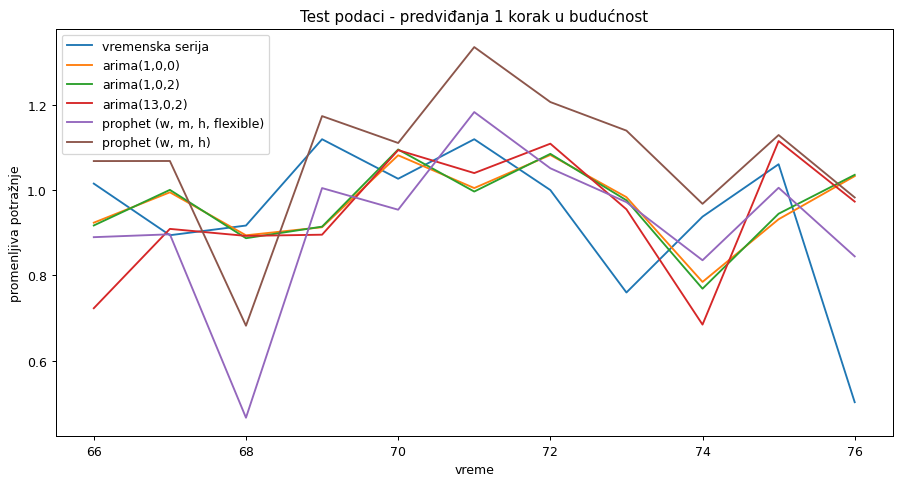

In [33]:
plt.figure(figsize=(12, 6))
plt.title("Test podaci - predviđanja 1 korak u budućnost")
plt.plot(actual['y'], label='vremenska serija')
plt.plot(final_df_2021_12['model__arima_1_0_0__T1'], label='arima(1,0,0)')
plt.plot(final_df_2021_12['model__arima_1_0_2__T1'], label='arima(1,0,2)')
plt.plot(final_df_2021_12['model__arima_13_0_2__T1'], label='arima(13,0,2)')
plt.plot(final_df_2021_12['model__prophet_weekly_and_monthly_and_holidays_more_flexible_trend__T1'], 
         label='prophet (w, m, h, flexible)')
plt.plot(final_df_2021_12['model__prophet_weekly_and_monthly_and_holidays__T1'], 
         label='prophet (w, m, h)')

plt.xlabel("vreme")
plt.ylabel("promenljiva potražnje")
plt.legend()
plt.savefig("../../grafici/test_nedeljni_modeli.eps", dpi=300)
plt.show()

In [ ]:
# 68. nedelja je Uskrs :/